In [1]:
# Importing needed packages:

import pandas as pd                                               # version: 2.0.3
import numpy as np                                                # version: 1.24.3
import scipy.stats as st                                          # version: 1.11.1
from scipy.stats import norm, t, f, levene, chi2, mannwhitneyu    # version: 1.11.1
from scipy import stats                                           # version: 1.11.1
import matplotlib.pyplot as plt                                   # version: 3.7.2
import matplotlib as mpl                                          # version: 3.7.2
from IPython.display import display                               # version: 8.15.0
import eurostat                                                   # version: 1.0.4
import seaborn as sns                                             # version: 0.12.2
import statsmodels.api as sm                                      # version: 0.14.0
from statsmodels.formula.api import ols                           # version: 0.14.0

In [2]:
# Please only two decimals in the output!!
# This line will give us just two decimals for every pd dataframe displayed
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# 3.1. Descriptive statistics

# 3.1.1 Dataset for 3.2. Confidence interval

In [3]:
# Passenger Journeys by Luas
# Source: https://data.gov.ie/dataset/tii03-passenger-journeys-by-luas
# Unit: Weekly passenger number
# Licence: https://creativecommons.org/licenses/by/4.0/
sdf = pd.read_csv('https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/TII03/CSV/1.0/en')

In [4]:
sdf.head()

,STATISTIC,Statistic Label,TLIST(W1),Week,C03132V03784,Luas Line,UNIT,VALUE
0,TII03C01,Passenger Journeys,2019W01,2019 Week 01,-,All Luas lines,Number,549533.00
1,TII03C01,Passenger Journeys,2019W01,2019 Week 01,1,Red line,Number,274139.00
2,TII03C01,Passenger Journeys,2019W01,2019 Week 01,2,Green line,Number,275394.00
3,TII03C01,Passenger Journeys,2019W02,2019 Week 02,-,All Luas lines,Number,839022.00
4,TII03C01,Passenger Journeys,2019W02,2019 Week 02,1,Red line,Number,408199.00


In [5]:
# Renaming columns
sdf = sdf.rename(columns={'Luas Line': 'Luas_Line'})

# Dropping the 'STATISTIC Label' column it's irrelevant for the analysis
sdf_col_drop = ['STATISTIC','Statistic Label','TLIST(W1)','C03132V03784','UNIT']
sdf.drop(sdf_col_drop ,axis=1, inplace=True) 

In [6]:
# Creating dataset sdfa dropping values for 'All Luas lines' we want to focus on 'Red line' and 'Green line'
sdfa = sdf[(sdf['Luas_Line'] != 'All Luas lines')]

In [7]:
# Checking sdfa info
sdfa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 520 entries, 1 to 779
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Week       520 non-null    object 
 1   Luas_Line  520 non-null    object 
 2   VALUE      514 non-null    float64
dtypes: float64(1), object(2)
memory usage: 16.2+ KB


In [8]:
# Display the rows with null values
sdfa_NaN = sdfa[sdfa.isnull().any(axis=1)]
print("Rows with null values:")
sdfa_NaN

Rows with null values:


,Week,Luas_Line,VALUE
157,2019 Week 53,Red line,NaN
158,2019 Week 53,Green line,NaN
475,2021 Week 53,Red line,NaN
476,2021 Week 53,Green line,NaN
634,2022 Week 53,Red line,NaN
635,2022 Week 53,Green line,NaN


In [9]:
#Dropping NaN
sdfa = sdfa.dropna(subset=['VALUE'])

In [10]:
#  Dropping '2020 Week 53' 
sdfa = sdfa[~sdfa['Week'].str.contains('Week 53')]

In [11]:
sdfa.head()

,Week,Luas_Line,VALUE
1,2019 Week 01,Red line,274139.00
2,2019 Week 01,Green line,275394.00
4,2019 Week 02,Red line,408199.00
5,2019 Week 02,Green line,430823.00
7,2019 Week 03,Red line,376785.00


In [12]:
# Extracting the year from Week column
sdfa['Year'] = pd.to_datetime(sdfa['Week'].str[:4] + ' ' + sdfa['Week'].str[-2:] + ' 1', format='%Y %W %w').dt.year

In [13]:
# Checking sdfa info
sdfa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 512 entries, 1 to 779
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Week       512 non-null    object 
 1   Luas_Line  512 non-null    object 
 2   VALUE      512 non-null    float64
 3   Year       512 non-null    int32  
dtypes: float64(1), int32(1), object(2)
memory usage: 18.0+ KB


In [14]:
sdfa.head()

,Week,Luas_Line,VALUE,Year
1,2019 Week 01,Red line,274139.00,2019
2,2019 Week 01,Green line,275394.00,2019
4,2019 Week 02,Red line,408199.00,2019
5,2019 Week 02,Green line,430823.00,2019
7,2019 Week 03,Red line,376785.00,2019


In [15]:
# Counting the values that each year has:
year_counts = sdfa['Year'].value_counts().sort_index()
year_counts

Year
2019    104
2020    104
2021    104
2022    104
2023     96
Name: count, dtype: int64

In [16]:
sdfa.to_csv('Luas_Journey.csv', index=False)

In [17]:
# Creating variables for each year and storing the values to perform Confidence Intervals:

sdfa_2019 = sdfa[(sdfa['Year'] == 2019)].copy()
sdfa_2019.reset_index(drop=True, inplace=True)
sdfa_2020 = sdfa[(sdfa['Year'] == 2020)].copy()
sdfa_2020.reset_index(drop=True, inplace=True)
sdfa_2021 = sdfa[(sdfa['Year'] == 2021)].copy()
sdfa_2021.reset_index(drop=True, inplace=True)
sdfa_2022 = sdfa[(sdfa['Year'] == 2022)].copy()
sdfa_2022.reset_index(drop=True, inplace=True)

In [18]:
sdfa_2019

,Week,Luas_Line,VALUE,Year
0,2019 Week 01,Red line,274139.00,2019
1,2019 Week 01,Green line,275394.00,2019
2,2019 Week 02,Red line,408199.00,2019
3,2019 Week 02,Green line,430823.00,2019
4,2019 Week 03,Red line,376785.00,2019
...,...,...,...,...
99,2019 Week 50,Green line,594869.00,2019
100,2019 Week 51,Red line,550775.00,2019
101,2019 Week 51,Green line,622699.00,2019
102,2019 Week 52,Red line,259211.00,2019


We need to find out the averages for each of the years to perform *Confidence Intervals* and *Hypothesis test*:

In [19]:
# Passing descriptive statistics for each year into variables
de_2019 = sdfa_2019.describe().drop('Year', axis=1)
de_2020 = sdfa_2020.describe().drop('Year', axis=1)
de_2021 = sdfa_2021.describe().drop('Year', axis=1)
de_2022 = sdfa_2022.describe().drop('Year', axis=1)

# Concatenating datasets side by side to have it visually handy
combined_desc = pd.concat([de_2019, de_2020, de_2021, de_2022], axis=1, keys=['2019', '2020', '2021', '2022'])

print('Descriptive Statistics:')
display(combined_desc)

Descriptive Statistics:


,2019,2020,2021,2022
,VALUE,VALUE,VALUE,VALUE
count,104.00,104.00,104.00,104.00
mean,462966.40,185157.01,187611.13,373602.25
std,58751.21,139494.87,82667.60,90580.59
min,259211.00,19727.00,64278.00,161546.00
25%,441097.25,92848.00,102652.50,306127.50
50%,464353.00,152092.00,195341.50,354642.00
75%,499103.25,203166.00,258089.00,442544.75
max,622699.00,482333.00,327777.00,547010.00


In [20]:
sdfa_2019_pivot = sdfa_2019.pivot_table(index=['Luas_Line'],columns='Year', values='VALUE', aggfunc='sum').reset_index()
sdfa_2020_pivot = sdfa_2020.pivot_table(index=['Luas_Line'],columns='Year', values='VALUE', aggfunc='sum').reset_index()
sdfa_2021_pivot = sdfa_2021.pivot_table(index=['Luas_Line'],columns='Year', values='VALUE', aggfunc='sum').reset_index()
sdfa_2022_pivot = sdfa_2022.pivot_table(index=['Luas_Line'],columns='Year', values='VALUE', aggfunc='sum').reset_index()

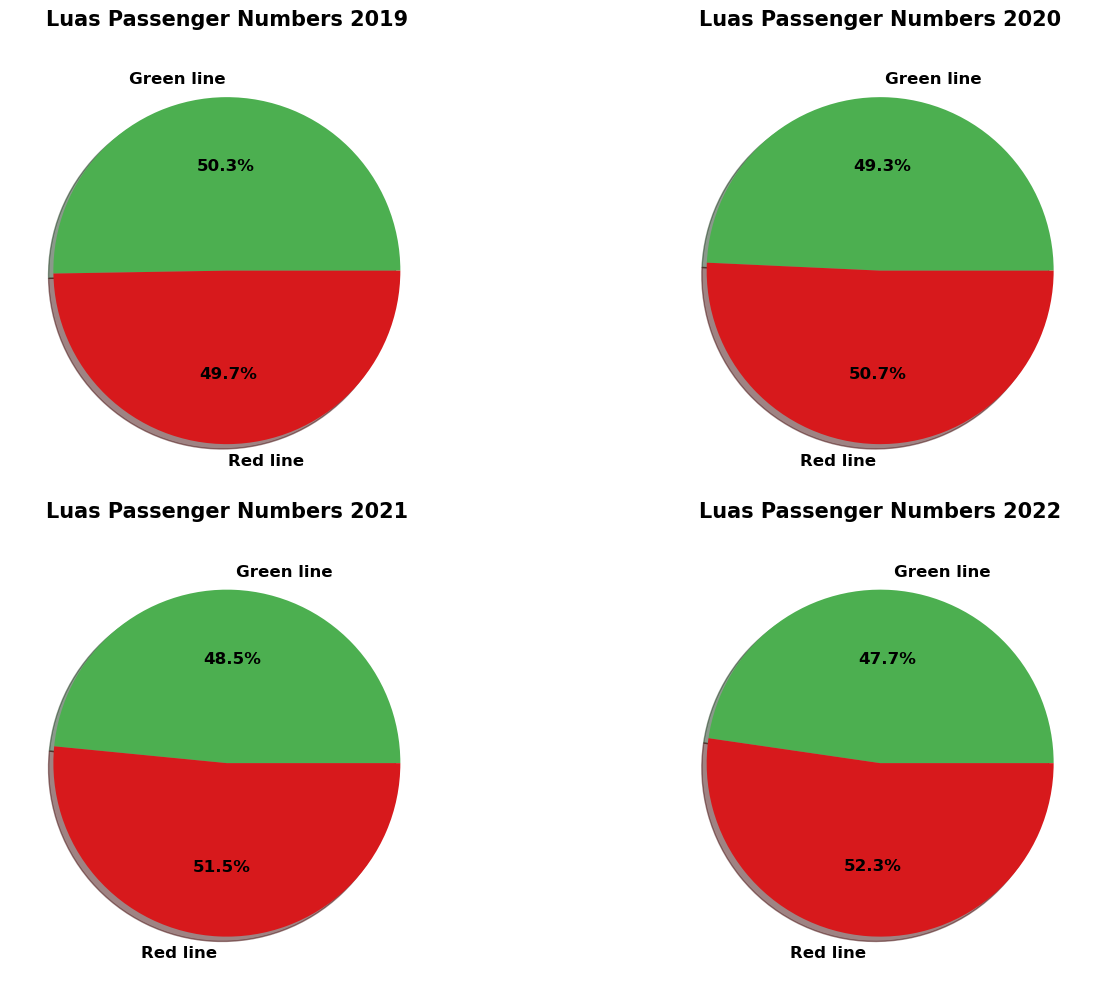

In [21]:
# Creating a table to summarise Luas Passenger Numbers
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Colours green and red to match Luas lines
pie_colors = ['#4CAF50', '#D7191C']

# Plot for 2019
sdfa_2019_pivot[2019].plot(kind='pie', labels=sdfa_2019_pivot['Luas_Line'], radius=1, autopct='%1.1f%%', shadow=True, colors=pie_colors, ax=axes[0, 0])
axes[0, 0].set_title('Luas Passenger Numbers 2019', loc="center", pad=20, fontsize=15, fontweight="bold")
axes[0, 0].set_ylabel("")

# Plot for 2020
sdfa_2020_pivot[2020].plot(kind='pie', labels=sdfa_2020_pivot['Luas_Line'], radius=1, autopct='%1.1f%%', shadow=True, colors=pie_colors, ax=axes[0, 1])
axes[0, 1].set_title('Luas Passenger Numbers 2020', loc="center", pad=20, fontsize=15, fontweight="bold")
axes[0, 1].set_ylabel("")

# Plot for 2021
sdfa_2021_pivot[2021].plot(kind='pie', labels=sdfa_2021_pivot['Luas_Line'], radius=1, autopct='%1.1f%%', shadow=True, colors=pie_colors, ax=axes[1, 0])
axes[1, 0].set_title('Luas Passenger Numbers 2021', loc="center", pad=20, fontsize=15, fontweight="bold")
axes[1, 0].set_ylabel("")

# Plot for 2022
sdfa_2022_pivot[2022].plot(kind='pie', labels=sdfa_2022_pivot['Luas_Line'], radius=1, autopct='%1.1f%%', shadow=True, colors=pie_colors, ax=axes[1, 1])
axes[1, 1].set_title('Luas Passenger Numbers 2022', loc="center", pad=20, fontsize=15, fontweight="bold")
axes[1, 1].set_ylabel("")

# Adjusting layout
plt.tight_layout()

# Adjusting font size for labels
for ax in axes.flatten():
    for text in ax.texts:
        text.set_fontsize(12)
        text.set_weight('bold')

plt.show()

# 3.1.2 Dataset for *3.3.1.1.	Hypothesis Test Two Populations*

In [22]:
# Modal split of inland passenger transport
# Unit of measure (% based on passenger-kilometres) : one passenger-km is one passenger transported over one kilometre
# https://ec.europa.eu/eurostat/databrowser/view/TRAN_HV_PSMOD__custom_2638259/bookmark/table?lang=en&bookmarkId=2d735f97-a7d6-4b24-bc27-a6c8e21db6a7
# Licence: https://ec.europa.eu/eurostat/about-us/policies/copyright
sdf1 = eurostat.get_data_df('TRAN_HV_PSMOD',True)                                                                 
sdf1.head()

,freq,unit,vehicle,geo\TIME_PERIOD,1990_value,1990_flag,1991_value,1991_flag,1992_value,1992_flag,...,2017_value,2017_flag,2018_value,2018_flag,2019_value,2019_flag,2020_value,2020_flag,2021_value,2021_flag
0,A,PC,BUS_TOT,AT,11.00,,10.60,,10.50,,...,10.00,,9.50,be,9.70,e,9.30,e,9.00,e
1,A,PC,BUS_TOT,BE,10.60,e,10.70,e,10.70,e,...,10.20,e,10.30,e,10.40,e,8.20,e,8.20,e
2,A,PC,BUS_TOT,BG,NaN,:,NaN,:,NaN,:,...,13.10,e,12.00,e,13.00,e,8.60,e,8.00,e
3,A,PC,BUS_TOT,CH,3.70,,3.90,,4.00,,...,5.90,e,5.90,e,6.10,e,5.80,e,5.90,e
4,A,PC,BUS_TOT,CY,NaN,:,NaN,:,NaN,:,...,19.00,e,18.90,e,18.50,e,12.60,e,12.70,e


In [23]:
# Tyding up sfd1

# Filter columns that do not contain '_flag'
sdf1 = sdf1.filter(regex='^(?!.*_flag)')

# Renaming columns
sdf1 = sdf1.rename(columns={'geo\\TIME_PERIOD': 'Country_code','vehicle':'Vehicle_type'})

# Dropping not needed rows:
# From column 'Vehicle_type' we don't need 'TRN_BUS_TOT_AVD'
# From column 'Country_code' we don't need 'EU27_2020' and 'EU28'
sdf1 = sdf1[(sdf1['Vehicle_type'] != 'TRN_BUS_TOT_AVD') & ~sdf1['Country_code'].isin(['EU27_2020', 'EU28'])]

# Drop rows with null values
sdf1 = sdf1.dropna()

# Dropping columns 'freq' and 'unit' we don't need them. Unit of measurement for this dataset is percentage
sdf1 = sdf1.drop(['freq', 'unit'], axis=1).reset_index(drop=True)

# Trimming 'BUS_TOT' to have just 'BUS'
sdf1['Vehicle_type'] = sdf1['Vehicle_type'].str.replace('_TOT', '')

# Concatenate 'Country_code' and 'Vehicle_type'
sdf1['Country_Vehicle'] = sdf1['Country_code'] + '_' + sdf1['Vehicle_type']

# Drop the original columns
sdf1 = sdf1.drop(['Vehicle_type', 'Country_code'], axis=1)

sdf1.head()

,1990_value,1991_value,1992_value,1993_value,1994_value,1995_value,1996_value,1997_value,1998_value,1999_value,...,2013_value,2014_value,2015_value,2016_value,2017_value,2018_value,2019_value,2020_value,2021_value,Country_Vehicle
0,11.00,10.60,10.50,10.70,10.60,10.90,10.70,10.90,10.90,10.70,...,9.90,9.90,9.90,9.90,10.00,9.50,9.70,9.30,9.00,AT_BUS
1,10.60,10.70,10.70,10.90,11.80,11.30,11.30,11.10,11.00,10.90,...,15.20,11.50,11.00,10.50,10.20,10.30,10.40,8.20,8.20,BE_BUS
2,3.70,3.90,4.00,3.90,4.00,3.80,3.60,3.60,5.30,5.20,...,5.70,5.80,5.90,5.90,5.90,5.90,6.10,5.80,5.90,CH_BUS
3,9.10,8.50,8.30,8.10,7.30,7.20,7.10,7.10,7.00,6.90,...,7.20,7.20,7.40,7.30,7.30,7.20,7.40,4.80,4.80,DE_BUS
4,11.30,11.10,15.20,15.30,15.50,16.60,17.40,16.90,14.10,13.90,...,9.80,9.80,9.80,9.80,10.00,9.60,9.20,6.80,7.10,DK_BUS


In [24]:
# We need to organise sdf1, basically I want to have 'Year', 'Country_Vehicle' and 'value'
    
# Empty list to store results, initialising it
final_list = []

# Iterating over columns to extract the year from columns
for col in sdf1.columns:
    if col.endswith('_value'):
        # Extracting each year from the columns
        year = col.split('_')[0]

        # Getting 'Vehicle_Country' for each row to get its corresponding values
        for index, row in sdf1.iterrows():
            value = row[col]
            country_vehicle = row['Country_Vehicle']
            category = col.split('_')[1]  # Extract the category from the column name

            # Appending the final list as a dictionary
            final_list.append({
                'Year': year,
                'Country_Vehicle': country_vehicle,
                'Category': category,
                'Value': value
            })
            
# Converting 'final_list' to a DataFrame
Y_CV_V_df = pd.DataFrame(final_list)

# Pivot the DataFrame
Y_CV_V_df = Y_CV_V_df.pivot_table(index=['Year', 'Country_Vehicle'], columns='Category', values='Value').reset_index()
Y_CV_V_df = Y_CV_V_df.rename_axis(None, axis=1) # Index with no name as it should be
   
sdf1 = Y_CV_V_df.copy() #Reusing variable sdf1

sdf1.head()

,Year,Country_Vehicle,value
0,1990,AT_BUS,11.00
1,1990,AT_CAR,77.10
2,1990,AT_TRN,11.90
3,1990,BE_BUS,10.60
4,1990,BE_CAR,83.30


In [25]:
# Pivot the DataFrame
sdf1 = sdf1.pivot(index='Year', columns='Country_Vehicle', values='value').reset_index()
sdf1 = sdf1.rename_axis(None, axis=1)
sdf1.head()

,Year,AT_BUS,AT_CAR,AT_TRN,BE_BUS,BE_CAR,BE_TRN,CH_BUS,CH_CAR,CH_TRN,...,PL_TRN,PT_BUS,PT_CAR,PT_TRN,SE_BUS,SE_CAR,SE_TRN,SI_BUS,SI_CAR,SI_TRN
0,1990,11.00,77.10,11.90,10.60,83.30,6.10,3.70,82.10,14.20,...,30.50,18.40,71.50,10.10,9.50,84.10,6.50,30.60,62.70,6.70
1,1991,10.60,77.00,12.40,10.70,83.30,6.10,3.90,81.10,15.00,...,24.60,18.60,71.40,9.90,9.50,84.70,5.90,29.30,66.40,4.30
2,1992,10.50,77.00,12.50,10.70,83.30,6.00,4.00,81.40,14.60,...,20.30,22.70,68.20,9.00,9.40,84.80,5.80,23.00,73.90,3.00
3,1993,10.70,77.20,12.10,10.90,83.30,5.90,3.90,80.90,15.20,...,17.70,19.30,72.20,8.50,9.30,84.40,6.30,21.10,75.80,3.10
4,1994,10.60,77.80,11.60,11.80,82.60,5.60,4.00,79.80,16.20,...,15.60,17.90,74.30,7.80,9.30,84.40,6.30,20.40,76.60,3.00


In [27]:
# Creating sdf4 for 
sdf4 = sdf1.copy()

In [28]:
# sdf1.describe(include='all').T # Transposing columns to see each Country_Vehicle
# passing the stats into 'sdf1b' dataframe
sdf1b = (sdf1.describe(include='all').T).reset_index().rename_axis(None, axis=1).copy()

# Dropping first row we don't need Years we already now that year range goes from 1990 to 2021
sdf1b = sdf1b.drop(0)

# Renaming columns
sdf1b = sdf1b.rename(columns={'index': 'Country_Vehicle'})
sdf1b.head(10)

,Country_Vehicle,count,unique,top,freq,mean,std,min,25%,50%,75%,max
1,AT_BUS,32.00,NaN,NaN,NaN,10.27,0.63,9.00,9.90,10.50,10.90,11.00
2,AT_CAR,32.00,NaN,NaN,NaN,78.61,1.25,76.40,77.70,78.90,79.53,81.50
3,AT_TRN,32.00,NaN,NaN,NaN,11.12,1.29,9.20,9.80,11.35,12.10,13.90
4,BE_BUS,32.00,NaN,NaN,NaN,11.60,1.59,8.20,10.70,11.20,12.85,15.20
5,BE_CAR,32.00,NaN,NaN,NaN,81.70,1.84,77.80,80.42,81.90,83.03,85.60
6,BE_TRN,32.00,NaN,NaN,NaN,6.71,0.74,5.60,6.07,6.55,7.33,8.20
7,CH_BUS,32.00,NaN,NaN,NaN,5.09,0.81,3.60,4.82,5.20,5.72,6.10
8,CH_CAR,32.00,NaN,NaN,NaN,78.53,2.88,73.90,75.00,79.55,81.03,82.50
9,CH_TRN,32.00,NaN,NaN,NaN,16.38,2.30,13.60,14.28,15.75,19.23,20.00
10,DE_BUS,32.00,NaN,NaN,NaN,7.00,0.86,4.80,6.70,7.10,7.30,9.10


In [29]:
# Filtering by each Vehicle, it will help visually to have each category grouped
sdf1_bus = sdf1b[sdf1b['Country_Vehicle'].str.contains('BUS')].drop(['unique', 'top','freq'], axis=1).sort_values(by='mean', ascending=False).reset_index(drop=True)
sdf1_car = sdf1b[sdf1b['Country_Vehicle'].str.contains('CAR')].drop(['unique', 'top','freq'], axis=1).sort_values(by='mean', ascending=False).reset_index(drop=True)
sdf1_trn = sdf1b[sdf1b['Country_Vehicle'].str.contains('TRN')].drop(['unique', 'top','freq'], axis=1).sort_values(by='mean', ascending=False).reset_index(drop=True)

In [30]:
from IPython.display import display
print('Descriptive Statistics for BUS, category:')
display(sdf1_bus)
print('Descriptive Statistics for CAR, category:')
display(sdf1_car)
print('Descriptive Statistics for TRAIN, category:')
display(sdf1_trn)

Descriptive Statistics for BUS, category:


,Country_Vehicle,count,mean,std,min,25%,50%,75%,max
0,HU_BUS,32.00,22.21,2.56,14.30,21.25,22.80,24.02,25.00
1,EL_BUS,32.00,22.08,6.27,12.30,17.45,19.60,28.12,32.40
2,PL_BUS,32.00,16.63,5.65,7.50,13.07,15.45,19.52,28.20
3,SI_BUS,32.00,14.62,5.50,7.50,11.40,11.80,17.07,30.60
4,IE_BUS,32.00,14.03,1.14,11.50,13.30,14.25,14.75,16.20
5,ES_BUS,32.00,12.76,3.44,6.40,11.88,13.00,13.55,23.30
6,IT_BUS,32.00,12.00,0.94,10.20,11.40,11.70,12.47,14.70
7,DK_BUS,32.00,11.74,2.81,6.80,9.80,10.80,14.00,17.40
8,BE_BUS,32.00,11.60,1.59,8.20,10.70,11.20,12.85,15.20
9,FI_BUS,32.00,11.03,1.43,8.30,9.90,10.50,12.22,13.50


Descriptive Statistics for CAR, category:


,Country_Vehicle,count,mean,std,min,25%,50%,75%,max
0,NL_CAR,32.00,86.12,1.49,82.90,85.40,86.00,87.22,90.10
1,FR_CAR,32.00,85.38,1.13,83.30,84.58,85.50,86.40,87.00
2,DE_CAR,32.00,85.35,1.17,83.30,84.50,85.40,85.80,88.80
3,LU_CAR,32.00,84.58,1.15,82.60,83.40,84.95,85.33,86.60
4,PT_CAR,32.00,84.52,7.14,68.20,80.00,89.15,89.70,93.00
5,FI_CAR,32.00,83.88,1.59,81.20,82.38,84.20,84.90,87.70
6,SE_CAR,32.00,83.50,1.34,79.50,83.40,83.90,84.10,84.80
7,IE_CAR,32.00,82.85,1.29,80.50,82.10,82.70,83.40,86.10
8,SI_CAR,32.00,82.72,6.28,62.70,80.40,85.60,86.43,91.20
9,IT_CAR,32.00,82.16,1.29,78.90,81.57,82.35,83.00,85.90


Descriptive Statistics for TRAIN, category:


,Country_Vehicle,count,mean,std,min,25%,50%,75%,max
0,CH_TRN,32.00,16.38,2.30,13.60,14.28,15.75,19.23,20.00
1,HU_TRN,32.00,11.17,2.13,6.00,10.00,11.85,12.90,14.70
2,AT_TRN,32.00,11.12,1.29,9.20,9.80,11.35,12.10,13.90
3,PL_TRN,32.00,10.43,5.82,4.90,6.90,8.35,11.00,30.50
4,NL_TRN,32.00,9.39,1.31,6.90,8.40,9.35,10.45,11.80
5,FR_TRN,32.00,9.03,0.82,7.50,8.35,9.10,9.80,10.30
6,DK_TRN,32.00,8.37,1.26,5.80,7.95,8.40,9.30,10.30
7,SE_TRN,32.00,8.20,1.66,5.80,6.78,7.75,9.25,12.20
8,DE_TRN,32.00,7.66,0.81,5.40,7.28,7.60,8.22,9.30
9,BE_TRN,32.00,6.71,0.74,5.60,6.07,6.55,7.33,8.20


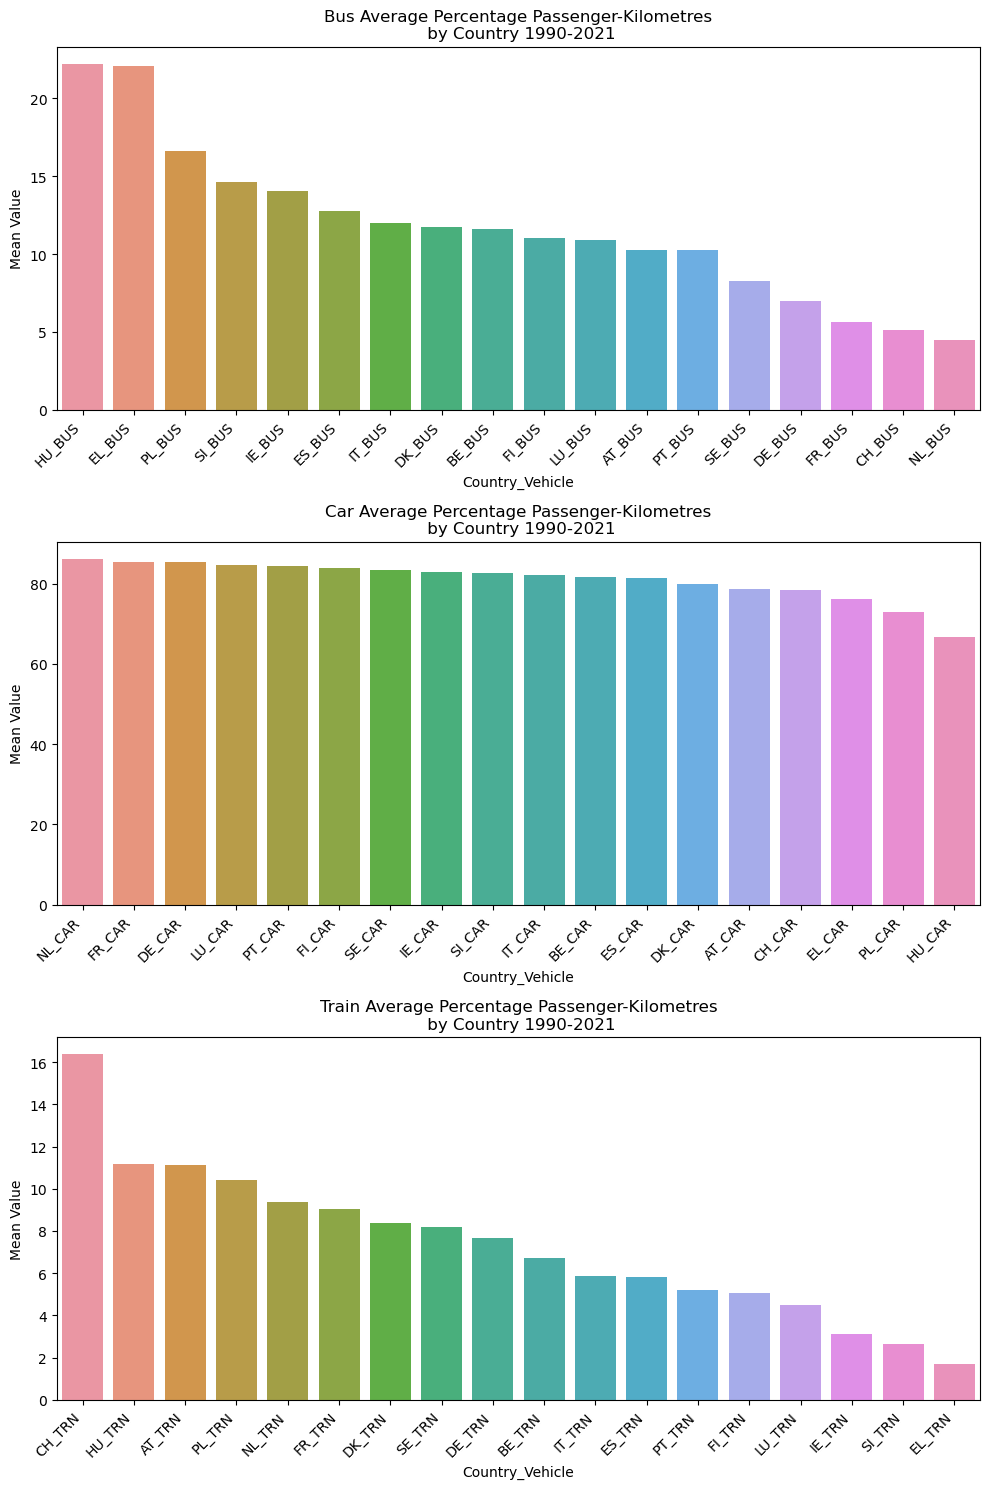

In [31]:
# Assuming sdf1_bus, sdf1_car, and sdf1_trn are your DataFrames
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot for Bus
sns.barplot(x='Country_Vehicle', y='mean', data=sdf1_bus, errorbar=None, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better visibility
axes[0].set_xlabel('Country_Vehicle')
axes[0].set_ylabel('Mean Value')
axes[0].set_title('Bus Average Percentage Passenger-Kilometres\n by Country 1990-2021')

# Plot for Car
sns.barplot(x='Country_Vehicle', y='mean', data=sdf1_car, errorbar=None, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better visibility
axes[1].set_xlabel('Country_Vehicle')
axes[1].set_ylabel('Mean Value')
axes[1].set_title('Car Average Percentage Passenger-Kilometres\n by Country 1990-2021')

# Plot for Train
sns.barplot(x='Country_Vehicle', y='mean', data=sdf1_trn, errorbar=None, ax=axes[2])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better visibility
axes[2].set_xlabel('Country_Vehicle')
axes[2].set_ylabel('Mean Value')
axes[2].set_title('Train Average Percentage Passenger-Kilometres\n by Country 1990-2021')

plt.tight_layout()
plt.show()


# 3.1.3 Dataset for *3.3.1.2.	Anova one-way*

In [32]:
# Air passenger transport by main airports in each reporting country
# Unit of measure: Annual passengers carried
# https://ec.europa.eu/eurostat/databrowser/view/AVIA_PAOA__custom_2638371/bookmark/table?lang=en&bookmarkId=9ff9f1d8-f4e7-4579-9454-806c644e90a1
# Licence: https://ec.europa.eu/eurostat/about-us/policies/copyright
sdf2 = eurostat.get_data_df('AVIA_PAOA',True) #It takes a bit to load...                                                             
sdf2.head()

,freq,unit,tra_meas,rep_airp,schedule,tra_cov\TIME_PERIOD,1993_value,1993_flag,1993-01_value,1993-01_flag,...,2023-09_value,2023-09_flag,2023-10_value,2023-10_flag,2023-Q1_value,2023-Q1_flag,2023-Q2_value,2023-Q2_flag,2023-Q3_value,2023-Q3_flag
0,A,FLIGHT,CAF_PAS,AT_LOWG,N_SCHED,INTL,1956.00,,NaN,:,...,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:
1,A,FLIGHT,CAF_PAS,AT_LOWG,N_SCHED,INTL_IEU27_2020,NaN,:,NaN,:,...,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:
2,A,FLIGHT,CAF_PAS,AT_LOWG,N_SCHED,INTL_IEU28,1525.00,,NaN,:,...,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:
3,A,FLIGHT,CAF_PAS,AT_LOWG,N_SCHED,INTL_XEU27_2020,NaN,:,NaN,:,...,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:
4,A,FLIGHT,CAF_PAS,AT_LOWG,N_SCHED,INTL_XEU28,431.00,,NaN,:,...,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:


In [33]:
# Creating a backup
sdf2_backup = sdf2.copy()

In [34]:
#sdf2 = sdf2_backup.copy()

In [35]:
# Tyding up sfd2
# Filter columns that do not contain '_flag'
sdf2 = sdf2.filter(regex='^(?!.*_flag)')
sdf2.head()

# We need to get annual passengers carried
# Filtering based on criteria from:
# https://ec.europa.eu/eurostat/databrowser/view/AVIA_PAOA__custom_2638371/bookmark/table?lang=en&bookmarkId=9ff9f1d8-f4e7-4579-9454-806c644e90a1
sdf2 = sdf2[(sdf2['freq'] == 'A') & (sdf2['tra_meas'] == 'PAS_BRD') &
            (sdf2['schedule'] == 'TOT')  & (sdf2['tra_cov\\TIME_PERIOD'] == 'TOTAL')]

# Kepping following columns
Col_no_drop = ['freq', 'unit', 'tra_meas', 'rep_airp', 'schedule', 'tra_cov\\TIME_PERIOD']
pattern = r'\d{4}_value'  # Matching 'YYYY_value' pattern

# Use a regular expression to filter columns
Col_filter = sdf2.columns[sdf2.columns.str.match(pattern)]  # Columns matching the pattern

# Combine additional columns with the filtered ones
Col_total = Col_no_drop + list(Col_filter)

# Filtering sdf2 wiht desired columns
sdf2 = sdf2[Col_total]

#Dropping not needed columns:

sdf2 = sdf2.drop(['freq', 'unit','tra_meas','schedule','tra_cov\\TIME_PERIOD'], axis=1).reset_index(drop=True)

# Renaming columns
sdf2 = sdf2.rename(columns={'rep_airp': 'Country_Icao'})

sdf2.head()

,Country_Icao,1993_value,1994_value,1995_value,1996_value,1997_value,1998_value,1999_value,2000_value,2001_value,...,2013_value,2014_value,2015_value,2016_value,2017_value,2018_value,2019_value,2020_value,2021_value,2022_value
0,AT_LOWG,393440.00,446219.00,496184.00,520286.00,593361.00,620805.00,645253.00,723932.00,722471.00,...,894785.00,911708.00,977732.00,990208.00,970037.00,1042519.00,1049248.00,201132.00,229492.00,568833.00
1,AT_LOWI,398493.00,421759.00,440038.00,472134.00,517649.00,585377.00,599678.00,667226.00,655949.00,...,991550.00,1004755.00,1011221.00,1013641.00,1095192.00,1125223.00,1151272.00,490108.00,126743.00,726695.00
2,AT_LOWK,199137.00,203699.00,200213.00,196849.00,218650.00,222716.00,212299.00,229157.00,224194.00,...,263835.00,227850.00,230338.00,196036.00,216784.00,229755.00,211153.00,49736.00,29722.00,83714.00
3,AT_LOWL,321129.00,390317.00,489119.00,573104.00,627838.00,640404.00,653807.00,707640.00,678682.00,...,560092.00,575012.00,541287.00,443273.00,413950.00,475124.00,445423.00,52755.00,70454.00,214199.00
4,AT_LOWS,970732.00,950530.00,1042219.00,1037924.00,1083428.00,1118521.00,1117161.00,1193228.00,1226085.00,...,1676525.00,1838545.00,1852219.00,1753698.00,1900799.00,1861010.00,1731428.00,675204.00,303746.00,1244528.00


In [36]:
# Importing icao codes to bring in airport names
# source: https://github.com/ip2location/ip2location-iata-icao/blob/master/iata-icao.csv
# Licence: https://creativecommons.org/licenses/by-sa/4.0/
sdf2a = pd.read_csv('iata-icao.csv')

sdf2a.head()

,country_code,region_name,iata,icao,airport,latitude,longitude
0,AE,Ash Shariqah,SHJ,OMSJ,Sharjah International Airport,25.33,55.52
1,AE,Abu Zaby,AZI,OMAD,Al Bateen Executive Airport,24.43,54.46
2,AE,Al Fujayrah,FJR,OMFJ,Fujairah International Airport,25.11,56.32
3,AE,Abu Zaby,XSB,OMBY,Sir Bani Yas Airport,24.28,52.58
4,AE,Ra's al Khaymah,RKT,OMRK,Ras Al Khaimah International Airport,25.61,55.94


In [37]:
# Create a new column by concatenating 'country_code' and 'Airport_Icao'
sdf2a['Country_Icao'] = sdf2a['country_code'] + '_' + sdf2a['icao']

# Renaming columns
sdf2a = sdf2a.rename(columns={'airport': 'Airport_Name'})

# Bringing in Airport Name to sdf2
sdf2 = pd.merge(sdf2, sdf2a[['Country_Icao', 'Airport_Name']], on='Country_Icao', how='inner')

# Move the 'Airport_Icao' column to the second position
sdf2.insert(1, 'Airport_Name', sdf2.pop('Airport_Name'))

# As Ireland is our baseline let's filter and see which airports we have
ireland_airports = sdf2[sdf2['Country_Icao'].str.startswith('IE_')].reset_index(drop=True)
pd.set_option('display.max_columns', None)
ireland_airports

,Country_Icao,Airport_Name,1993_value,1994_value,1995_value,1996_value,1997_value,1998_value,1999_value,2000_value,2001_value,2002_value,2003_value,2004_value,2005_value,2006_value,2007_value,2008_value,2009_value,2010_value,2011_value,2012_value,2013_value,2014_value,2015_value,2016_value,2017_value,2018_value,2019_value,2020_value,2021_value,2022_value
0,IE_EICK,Cork Airport,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,2192643.00,2265901.00,2747190.00,3023527.00,3183146.00,3258967.00,2767776.00,2422872.00,2358904.00,2333643.00,2252636.00,2138057.00,2065678.00,2226231.00,2301450.00,2387806.00,2585466.00,527014.00,255014.00,2238455.00
1,IE_EICM,Galway Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,257400.00,245918.00,90018.00,266473.00,195804.00,154814.00,67134.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IE_EIDW,Dublin Airport,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,15915900.00,17167371.00,18504763.00,21265834.00,23307302.00,23506926.00,20507456.00,18426823.00,18758105.00,19090781.00,20148574.00,21694893.00,24962518.00,27778845.00,29454474.00,31319419.00,32676251.00,7267240.00,8266271.00,27793345.00
3,IE_EIKN,Ireland West Airport Knock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,524648.00,608257.00,544042.00,629712.00,606421.00,586393.00,614172.00,677368.00,665558.00,703670.00,684671.00,735869.00,748505.00,770908.00,805443.00,142532.00,174027.00,709540.00
4,IE_EIKY,Kerry Airport (Farranfore Airport),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,385825.00,392576.00,391138.00,419941.00,356737.00,383866.00,292353.00,280688.00,306042.00,294955.00,303039.00,325670.00,335480.00,365339.00,369836.00,82959.00,115398.00,355043.00
5,IE_EINN,Shannon Airport,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,2481372.00,2486478.00,3268522.00,3690889.00,3524450.00,2956327.00,2579676.00,1531309.00,1364955.00,1286139.00,1308242.00,1555225.00,1642888.00,1674567.00,1599390.00,1677661.00,1616085.00,273934.00,322158.00,1421957.00


In [38]:
# As Dublin airport only has data from 2003 onwards, we are going to drop previous years

# List of columns to drop
drop_1993_2002 = [f'{year}_value' for year in range(1993, 2003)]

# Drop the columns
sdf2 = sdf2.drop(columns=drop_1993_2002)

In [39]:
# We need to organise sdf2, basically I want to have 'Year', 'Country_Icao', 'Airport_Name' and 'value'
    
# Empty list to store results, initialising it
final_list = []

# Iterating over columns to extract the year from columns
for col in sdf2.columns:
    if col.endswith('_value'):
        # Extracting each year from the columns
        year = col.split('_')[0]

        # Getting 'Vehicle_Country' for each row to get its corresponding values
        for index, row in sdf2.iterrows():
            value = row[col]
            Country_Icao = row['Country_Icao']
            Airport_Name = row['Airport_Name']
            category = col.split('_')[1]  # Extract the category from the column name

            # Appending the final list as a dictionary
            final_list.append({
                'Year': year,
                'Country_Icao': Country_Icao,
                'Airport_Name': Airport_Name,
                'Category': category,
                'Value': value
            })
            
# Converting 'final_list' to a DataFrame
sdf2_final = pd.DataFrame(final_list)

# Pivot the DataFrame
sdf2_final = sdf2_final.pivot_table(index=['Year', 'Country_Icao','Airport_Name'], columns='Category', values='Value').reset_index()
sdf2_final = sdf2_final.rename_axis(None, axis=1) # Index with no name as it should be
   
sdf2 = sdf2_final.copy() #Reusing variable sdf2

sdf2.head()

,Year,Country_Icao,Airport_Name,value
0,2003,AT_LOWG,Graz Airport,880976.00
1,2003,AT_LOWI,Innsbruck Airport (Kranebitten Airport),699715.00
2,2003,AT_LOWK,Klagenfurt Airport,313957.00
3,2003,AT_LOWL,Linz Airport (Blue Danube Airport),673975.00
4,2003,AT_LOWS,Salzburg Airport,1294648.00


In [40]:
sdf2.to_csv('Airports.csv', index=False)

Now we are going to create 'sdf2b' to get a descriptive statistic summary of
each airport that will help in the analysis.

In [41]:
sdf2b = sdf2.copy()

In [42]:
# We need to drop Airport_Name to simplify things
sdf2b = sdf2b.drop(['Airport_Name'], axis=1).reset_index()

# Pivot the DataFrame
sdf2b = sdf2b.pivot(index='Year', columns='Country_Icao', values='value').reset_index()
sdf2b = sdf2b.rename_axis(None, axis=1)


sdf2b = (sdf2b.describe(include='all').T).drop(['unique', 'top','freq'], axis=1).reset_index().rename_axis(None, axis=1).copy()

# Dropping first row we don't need Years we already now that year range goes from 1990 to 2021
sdf2b = sdf2b.drop(0)

# Renaming columns
sdf2b = sdf2b.rename(columns={'index': 'Country_Icao'})

# Bringing in Airport Name to sdf2b
sdf2b = pd.merge(sdf2b, sdf2a[['Country_Icao', 'Airport_Name']], on='Country_Icao', how='inner')
# Move the 'Airport_Icao' column to the second position
sdf2b.insert(1, 'Airport_Name', sdf2b.pop('Airport_Name'))

sdf2b

,Country_Icao,Airport_Name,count,mean,std,min,25%,50%,75%,max
0,AT_LOWG,Graz Airport,20.00,872575.40,246184.40,201132.00,907477.25,960204.00,992959.00,1049248.00
1,AT_LOWI,Innsbruck Airport (Kranebitten Airport),20.00,878784.70,243069.34,126743.00,748671.50,976909.50,1011826.00,1151272.00
2,AT_LOWK,Klagenfurt Airport,20.00,293914.55,145599.95,29722.00,215376.25,274073.50,415246.00,524111.00
3,AT_LOWL,Linz Airport (Blue Danube Airport),20.00,564152.95,237035.85,52755.00,444885.50,608003.00,746464.25,844330.00
4,AT_LOWS,Salzburg Airport,20.00,1582655.40,424559.25,303746.00,1542566.00,1724561.00,1841963.50,1975784.00
...,...,...,...,...,...,...,...,...,...,...
476,TR_LTFH,Samsun-Carsamba Airport,11.00,1384963.55,292965.98,870554.00,1192673.00,1335758.00,1621216.50,1790018.00
477,TR_LTFJ,Sabiha Gokcen International Airport,11.00,26249999.27,7045902.28,14813383.00,21093871.50,28191379.00,31092078.50,35566701.00
478,TR_LTFK,Gokceada Airport,2.00,1696.00,42.43,1666.00,1681.00,1696.00,1711.00,1726.00
479,TR_LTFM,Istanbul Ataturk Airport,5.00,35453324.60,25092597.00,95205.00,23415111.00,37192641.00,52031566.00,64532100.00


In [43]:
sdf2b.to_csv('Airports_Info.csv', index=False)

In [44]:
# As Ireland is our baseline let's filter and see which airports we have
ireland_airports = sdf2b[sdf2b['Country_Icao'].str.startswith('IE_')].reset_index(drop=True)
pd.set_option('display.max_columns', None)
ireland_airports

,Country_Icao,Airport_Name,count,mean,std,min,25%,50%,75%,max
0,IE_EICK,Cork Airport,20.00,2276618.80,731636.89,255014.00,2217834.00,2317546.50,2625897.00,3258967.00
1,IE_EICM,Galway Airport,7.00,182508.71,81126.51,67134.00,122416.00,195804.00,251659.00,266473.00
2,IE_EIDW,Dublin Airport,20.00,21390654.55,6668767.34,7267240.00,18485278.00,20886645.00,25666599.75,32676251.00
3,IE_EIKN,Ireland West Airport Knock,18.00,607318.67,180209.53,142532.00,591400.00,647635.00,708072.50,805443.00
4,IE_EIKY,Kerry Airport (Farranfore Airport),18.00,319826.94,89962.72,82959.00,296976.00,345261.50,380358.50,419941.00
5,IE_EINN,Shannon Airport,20.00,1913111.20,944315.04,273934.00,1407706.50,1629486.50,2509777.50,3690889.00


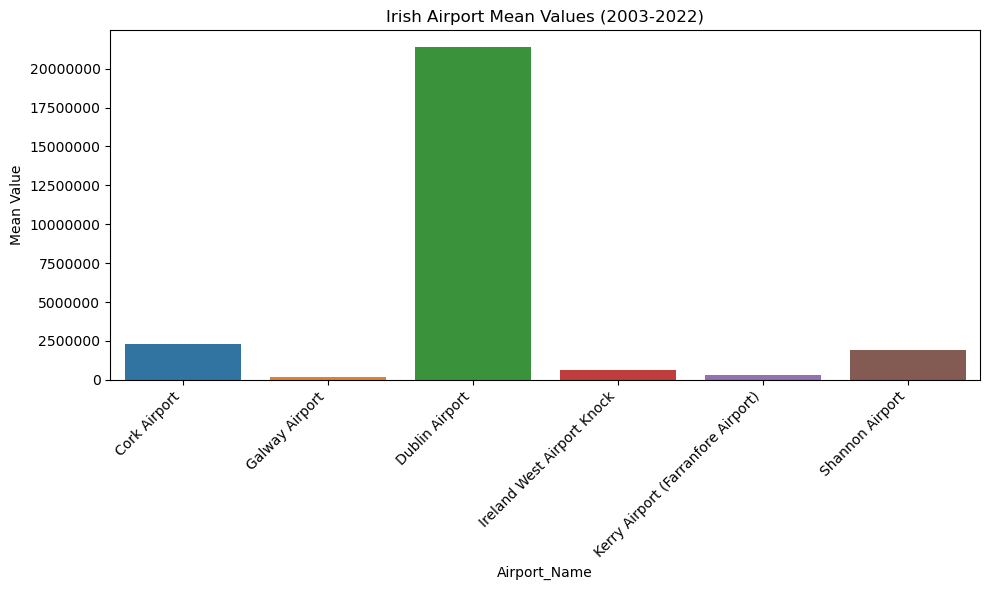

In [45]:
# Assuming df is your DataFrame
plt.figure(figsize=(10, 6))
sns.barplot(x='Airport_Name', y='mean', data=ireland_airports)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.xlabel('Airport_Name')
plt.ylabel('Mean Value')

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')
plt.title('Irish Airport Mean Values (2003-2022)')
plt.tight_layout()
plt.show()


# 1. First Scenario Dublin Airport Anova test:

Dublin Airport is our choice as it is the main airport in Ireland, values:<br>
**mean:** 21390654.55<br>
**std:** 6668767.341634<br>
The task now is to find a range of airports closer in terms of *mean* and *std*<br>
to accept the Null hypothesis.

In [46]:
# Filtering the 'mean' column
Anova_subset = (sdf2b[(sdf2b['mean'] > 18000000) & (sdf2b['mean'] < 23000000)]).reset_index(drop=True)
Anova_subset

,Country_Icao,Airport_Name,count,mean,std,min,25%,50%,75%,max
0,AT_LOWW,Vienna International Airport,20.00,19857100.95,5674227.81,7876108.00,16609480.75,20479758.50,23073806.25,31783420.00
1,BE_EBBR,Brussels Airport (Zaventem Airport),20.00,18574541.75,4916594.59,6770442.00,16565277.50,18806152.50,21910653.00,26417507.00
2,CH_LSZH,Zurich Airport,20.00,22323189.95,6099510.33,8314350.00,19175414.50,22717153.50,25699659.75,31510469.00
3,DE_EDDL,Dusseldorf Airport,20.00,18504338.50,5069179.18,6576778.00,15943037.00,18594106.00,22016241.75,25496594.00
4,DK_EKCH,Copenhagen Airport,20.00,22055412.75,6042364.94,7517006.00,19895719.75,21810180.00,25917378.00,30262426.00
5,ES_LEPA,Palma de Mallorca Airport,20.00,22388415.20,5318551.13,6099346.00,21133396.75,22720137.00,24351253.50,29625649.00
6,IE_EIDW,Dublin Airport,20.00,21390654.55,6668767.34,7267240.00,18485278.00,20886645.00,25666599.75,32676251.00
7,IT_LIMC,Milan-Malpensa Airport,20.00,19296700.20,4630696.68,7274756.00,18536291.50,19296227.50,21565573.25,28945027.00
8,NO_ENGM,Oslo Airport,20.00,20133509.35,5731339.17,8990074.00,17162784.75,20162656.50,24257693.75,28475439.00
9,SE_ESSA,Stockholm Arlanda Airport,20.00,18917401.10,5423224.41,6575887.00,16873244.75,18346582.50,22650002.00,26953307.00


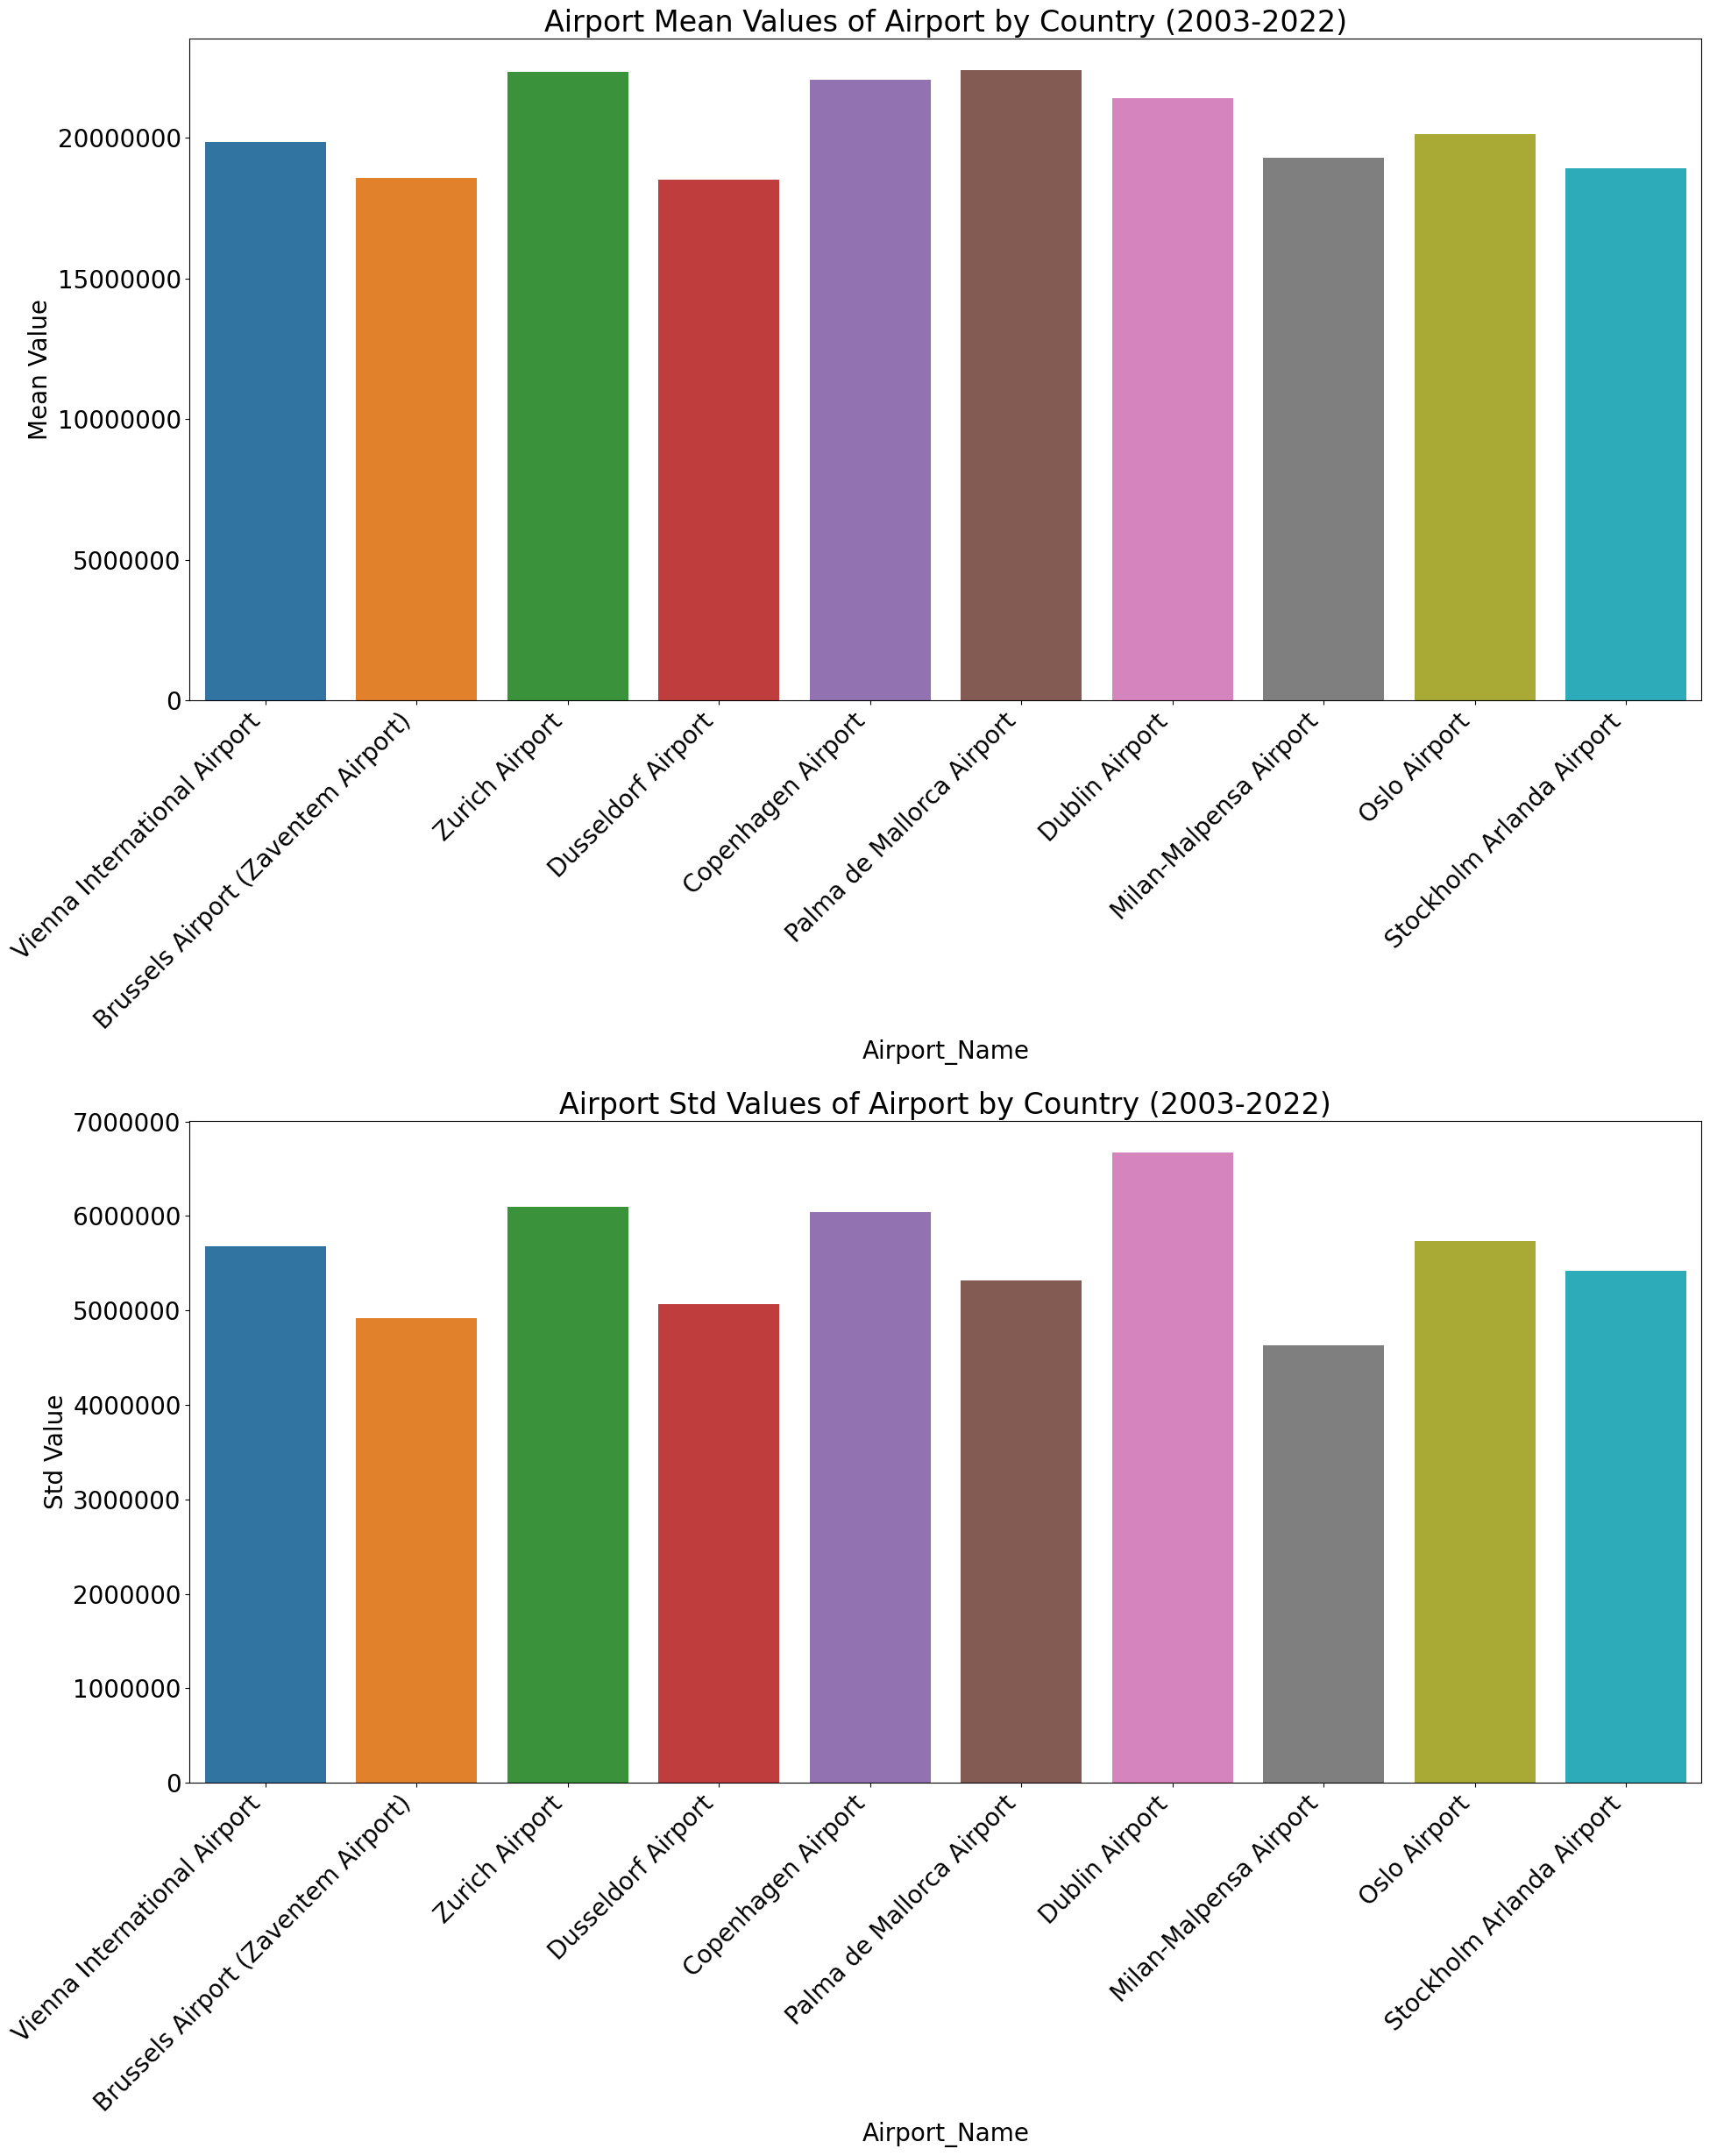

In [47]:
# Increase font size globally
mpl.rcParams['font.size'] = 20

# Assuming Anova_subset is your DataFrame
plt.figure(figsize=(20, 25))

# First subplot (mean values)
plt.subplot(2, 1, 1)
sns.barplot(x='Airport_Name', y='mean', data=Anova_subset)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.xlabel('Airport_Name')
plt.ylabel('Mean Value')
plt.title('Airport Mean Values of Airport by Country (2003-2022)')

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

# Second subplot (std values)
plt.subplot(2, 1, 2)
sns.barplot(x='Airport_Name', y='std', data=Anova_subset)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.xlabel('Airport_Name')
plt.ylabel('Std Value')
plt.title('Airport Std Values of Airport by Country (2003-2022)')

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

I'm going to select *Zurich Airport* and *Copenhagen Airport* to perform Anova<br> having *Dublin Airport* as our reference.

# 2. Second Scenario Shannon Airport Anova test:

In [48]:
# Filtering the 'mean' column
Anova_subset = (sdf2b[(sdf2b['mean'] > 1900000) & (sdf2b['mean'] < 2300000) & (sdf2b['count'] == 20)]).reset_index(drop=True)
Anova_subset 

,Country_Icao,Airport_Name,count,mean,std,min,25%,50%,75%,max
0,CY_LCPH,Paphos International Airport,20.00,2073751.55,566947.18,631983.00,1794078.50,1980211.50,2295934.75,3177855.00
1,DE_EDDP,Leipzig/Halle Airport,20.00,2262762.55,666562.11,533557.00,2161299.25,2363042.00,2641157.75,3035073.00
2,DE_EDDW,Bremen Airport,20.00,2124873.90,653499.88,595215.00,1706393.00,2454981.00,2570215.50,2777950.00
3,ES_LEST,Santiago de Compostela Airport,20.00,2111764.45,544290.61,929973.00,1852305.75,2066660.50,2459937.50,3293564.00
4,IE_EICK,Cork Airport,20.00,2276618.80,731636.89,255014.00,2217834.00,2317546.50,2625897.00,3258967.00
5,IE_EINN,Shannon Airport,20.00,1913111.20,944315.04,273934.00,1407706.50,1629486.50,2509777.50,3690889.00
6,IT_LIEO,Olbia Costa Smeralda Airport,20.00,2055811.70,563386.94,1024739.00,1703680.75,1874206.00,2300835.25,3161713.00
7,IT_LIPH,Treviso-Sant'Angelo Airport,20.00,1901615.10,839345.47,463626.00,1271781.50,1957093.00,2442266.75,3304285.00
8,IT_LIRQ,Florence Airport,20.00,1910437.05,576281.29,667665.00,1645583.75,1912469.50,2282154.00,2861616.00
9,LU_ELLX,Luxembourg Findel Airport,20.00,2295873.70,971373.22,1425588.00,1582420.75,1864837.00,2734330.75,4364168.00


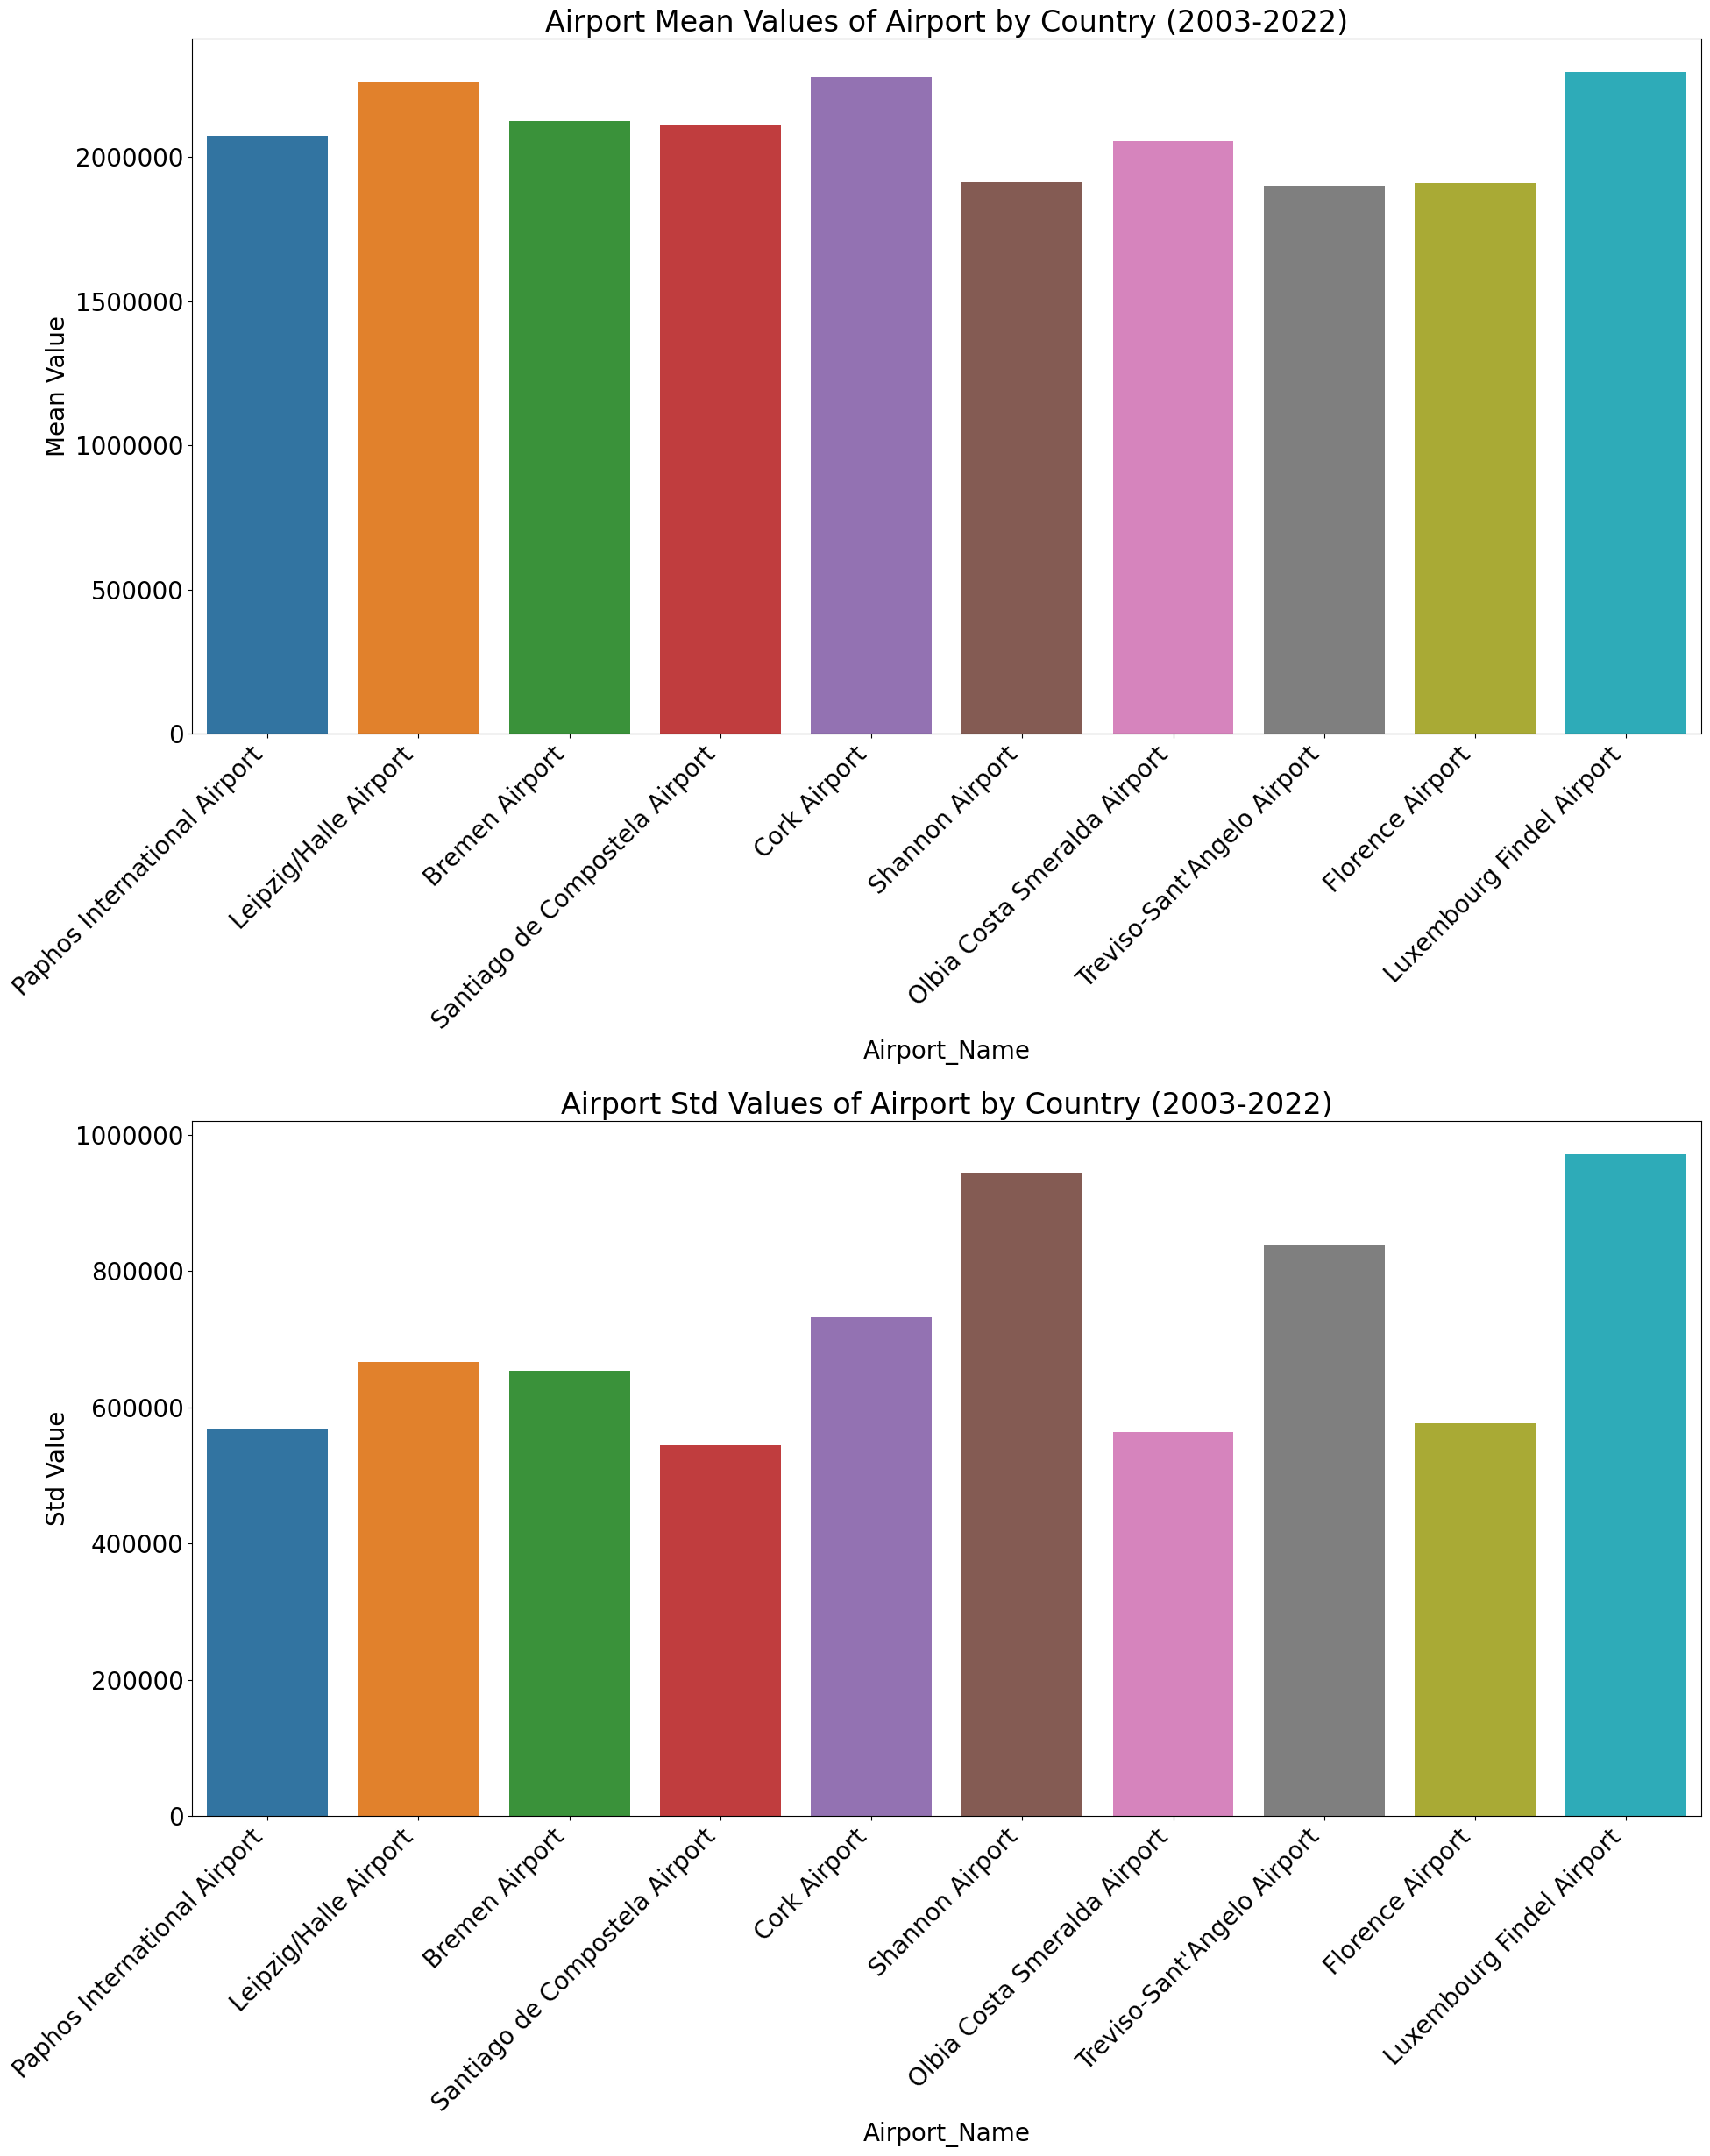

In [49]:
# Increase font size globally
mpl.rcParams['font.size'] = 20

# Assuming Anova_subset is your DataFrame
plt.figure(figsize=(20, 25))

# First subplot (mean values)
plt.subplot(2, 1, 1)
sns.barplot(x='Airport_Name', y='mean', data=Anova_subset)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.xlabel('Airport_Name')
plt.ylabel('Mean Value')
plt.title('Airport Mean Values of Airport by Country (2003-2022)')

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

# Second subplot (std values)
plt.subplot(2, 1, 2)
sns.barplot(x='Airport_Name', y='std', data=Anova_subset)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.xlabel('Airport_Name')
plt.ylabel('Std Value')
plt.title('Airport Std Values of Airport by Country (2003-2022)')

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# Reset all parameters to their default values
mpl.rcParams.update(mpl.rcParamsDefault)

In [50]:
sdf2c = sdf2b.copy()

In [51]:
sdf2c = sdf2c.loc[sdf2c['count']==20].sort_values(by='mean', ascending=False).reset_index(drop=True)
sdf2c = sdf2c.iloc[:15].copy()
sdf2c

,Country_Icao,Airport_Name,count,mean,std,min,25%,50%,75%,max
0,FR_LFPG,Paris Charles de Gaulle Airport,20.00,57434595.80,13232397.96,22262748.00,55681803.25,60022740.00,64285292.25,76195486.00
1,DE_EDDF,Frankfurt Airport,20.00,53487975.80,12477672.53,18788995.00,51368507.25,54044868.00,59982701.00,70634781.00
2,NL_EHAM,Amsterdam Airport Schiphol,20.00,49904018.90,13167060.66,20888227.00,44065397.25,48843909.00,55850838.50,71742574.00
3,ES_LEMD,Adolfo Suarez Madrid-Barajas Airport,20.00,44537887.75,10347249.24,16506150.00,41112939.75,47210087.00,50348261.25,59816612.00
4,DE_EDDM,Munich Airport,20.00,33959682.65,9847632.88,11116926.00,30275985.00,34667496.50,40108252.50,47963043.00
5,ES_LEBL,Barcelona El Prat Airport,20.00,33496382.80,10242059.66,12461563.00,27218517.50,33576782.50,40083832.00,51754419.00
6,IT_LIRF,Rome–Fiumicino International Airport,20.00,33221610.65,9255464.09,9885587.00,29341863.25,36013306.50,38945416.75,43657541.00
7,ES_LEPA,Palma de Mallorca Airport,20.00,22388415.20,5318551.13,6099346.00,21133396.75,22720137.00,24351253.50,29625649.00
8,CH_LSZH,Zurich Airport,20.00,22323189.95,6099510.33,8314350.00,19175414.50,22717153.50,25699659.75,31510469.00
9,DK_EKCH,Copenhagen Airport,20.00,22055412.75,6042364.94,7517006.00,19895719.75,21810180.00,25917378.00,30262426.00


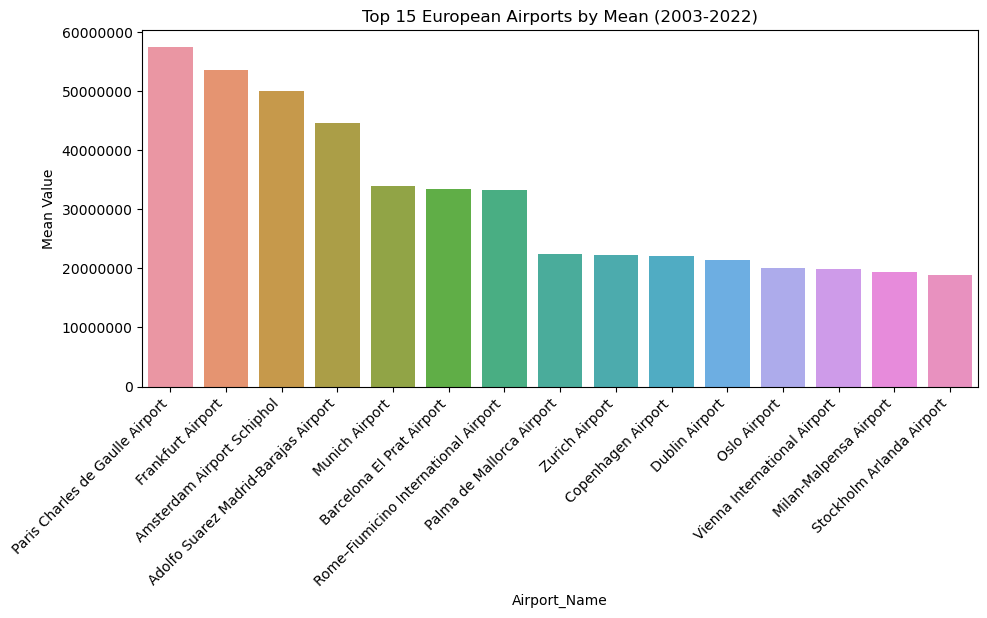

In [52]:
# Assuming Anova_subset is your DataFrame
plt.figure(figsize=(10, 10))

# First subplot (mean values)
plt.subplot(2, 1, 1)
sns.barplot(x='Airport_Name', y='mean', data=sdf2c)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.xlabel('Airport_Name')
plt.ylabel('Mean Value')
plt.title('Top 15 European Airports by Mean (2003-2022)')

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# 3.1.4 Dataset for *3.3.1.3.	Chi-squared test*

In [53]:
# New passenger cars by type of motor energy
# Unit of measure: Registrations of new passenger cars by type of motor energy (number)
# https://ec.europa.eu/eurostat/databrowser/view/ROAD_EQR_CARPDA__custom_2784054/bookmark/table?lang=en&bookmarkId=6fa608a8-450f-4e81-8e8e-33f57ab73bd3
# Licence: https://ec.europa.eu/eurostat/about-us/policies/copyright
sdf3 = eurostat.get_data_df('road_eqr_carpda',True)                                                                 
sdf3.head()

,freq,unit,mot_nrg,geo\TIME_PERIOD,2012_value,2012_flag,2013_value,2013_flag,2014_value,2014_flag,2015_value,2015_flag,2016_value,2016_flag,2017_value,2017_flag,2018_value,2018_flag,2019_value,2019_flag,2020_value,2020_flag,2021_value,2021_flag,2022_value,2022_flag
0,A,NR,ALT,AL,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:,3757.00,,4935.00,,5703.00,,4114.00,
1,A,NR,ALT,AT,NaN,:,1285.00,,2074.00,,2389.00,,4317.00,,5868.00,,7406.00,,9841.00,,16393.00,,33466.00,,34242.00,
2,A,NR,ALT,BA,NaN,:,39.00,,46.00,,49.00,,141.00,,136.00,,41.00,,137.00,,73.00,,229.00,,300.00,
3,A,NR,ALT,BE,NaN,:,841.00,,2234.00,,2147.00,,4413.00,,5418.00,,7931.00,,12525.00,,18920.00,,25867.00,,40656.00,
4,A,NR,ALT,BG,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:,NaN,:,23.00,,NaN,:


In [54]:
# Tyding up sdf3
# Filter columns that do not contain '_flag'
sdf3 = sdf3.filter(regex='^(?!.*_flag)')
# Renaming columns
sdf3 = sdf3.rename(columns={'geo\\TIME_PERIOD': 'Country_code','mot_nrg':'Motor_energy_type'})

# Dropping not needed rows:

# From column 'Motor_energy_type' we only want 'ALT', 'DIE' and 'ELC'
sdf3 = sdf3[sdf3['Motor_energy_type'].isin(['DIE', 'ELC', 'PET'])]

# Relabelling categories column Motor_energy_type
sdf3['Motor_energy_type'] = sdf3['Motor_energy_type'].replace({
    'DIE': 'Diesel',
    'ELC': 'Electric',
    'PET': 'Petroleum'
})

# Dropping columns 'freq' and 'unit' we don't need them. Unit of measurement for this dataset is percentage
sdf3 = sdf3.drop(['freq', 'unit'], axis=1).reset_index(drop=True)

# Drop rows with null values
sdf3 = sdf3.dropna()

sdf3.head()

,Motor_energy_type,Country_code,2012_value,2013_value,2014_value,2015_value,2016_value,2017_value,2018_value,2019_value,2020_value,2021_value,2022_value
29,Diesel,PL,450827.00,102026.00,120616.00,118900.00,131300.00,135100.00,130700.00,110600.00,80900.00,107852.00,99869.00
105,Petroleum,PL,399195.00,185427.00,156870.00,231619.00,279656.00,344340.00,400747.00,439677.00,334136.00,322308.00,298162.00


In [55]:
sdf3.to_csv('type_motor_energy.csv', index=False)

# Scenario 1:
(Rejecting H0)

In [56]:
# Filtering 'Country_Code', 'Motor_energy_type' and '2022_value'
columns_to_select = ['Country_code', 'Motor_energy_type', '2022_value']
sdf3a = sdf3.loc[sdf3['Country_code'].isin(['IE', 'AT']), columns_to_select].reset_index(drop=True)
sdf3a = pd.crosstab(sdf3a['Motor_energy_type'], sdf3a['Country_code'], values=sdf3a['2022_value'], aggfunc='sum', margins=False)
sdf3a

Country_code
Motor_energy_type


In [57]:
# Plotting histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot for Austria
sdf3a['AT'].plot(kind='bar', ax=axes[0], title='Registrations of new passenger cars\n by type of motor energy, Austria 2022')
axes[0].set_ylabel('Number of Registrations')
# Plot for Ireland
sdf3a['IE'].plot(kind='bar', ax=axes[1], title='Registrations of new passenger cars\n by type of motor energy, Ireland 2022')
axes[1].set_ylabel('Number of Registrations')
plt.tight_layout()
plt.show()

KeyError: 'AT'

# Scenario 2:
(Accepting H0)

In [ ]:
# Manually changing values for AT
sdf3b = {
    'Country_code': ['AT', 'IE', 'AT', 'IE', 'AT', 'IE'],
    'Motor_energy_type': ['Diesel', 'Diesel', 'Electric', 'Electric', 'Petroleum', 'Petroleum'],
    '2022_value': [31680.0, 31336.0, 16530.0, 15872.0, 60451.0, 59687.0]
}

sdf3b = pd.DataFrame(sdf3b)

sdf3b = pd.crosstab(sdf3b['Motor_energy_type'], sdf3b['Country_code'], values=sdf3b['2022_value'], aggfunc='sum', margins=False)
sdf3b

In [ ]:
# Plotting histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot for Austria
sdf3b['AT'].plot(kind='bar', ax=axes[0], title='Registrations of new passenger cars\n by type of motor energy, Austria 2022')
axes[0].set_ylabel('Number of Registrations')
# Plot for Ireland
sdf3b['IE'].plot(kind='bar', ax=axes[1], title='Registrations of new passenger cars\n by type of motor energy, Ireland 2022')
axes[1].set_ylabel('Number of Registrations')
plt.tight_layout()
plt.show()

#  3.1.5 Dataset for *3.3.2.1.	Kruskal-Wallis*

Dataset used is the same as used in *3.3.1.2.	Anova one-way*, sdf2.

In [ ]:
sdf2

In [ ]:
sdf2b

In [ ]:
# As Ireland is our baseline let's filter and see which airports we have
ireland_airports_stats = sdf2b[sdf2b['Country_Icao'].str.startswith('IE_')].reset_index(drop=True)
pd.set_option('display.max_columns', None)
ireland_airports_stats

# Scenario 1:
Accepting (H0)

Ireland West Airport Knock is our choice as Ireland is our reference in this assignment, values:<br>
**mean:** 607318.66<br>
**std:** 180209.53<br>
The task now is to find a range of airports closer in terms of *mean* and *std*<br>
to accept the Null hypothesis.

In [ ]:
# Filtering the 'mean' column
KW_subset = (sdf2b[(sdf2b['mean'] > 605000) & (sdf2b['mean'] < 620000)]).reset_index(drop=True)
KW_subset


In [ ]:
# Increase font size globally
mpl.rcParams['font.size'] = 25

# Assuming Anova_subset is your DataFrame
plt.figure(figsize=(25, 30))

# First subplot (mean values)
plt.subplot(2, 1, 1)
sns.barplot(x='Airport_Name', y='mean', data=KW_subset)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.xlabel('Airport_Name')
plt.ylabel('Mean Value')
plt.title('Kruskal-Wallis Airport Mean Values of Airport by Country (2003-2022)')

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

# Second subplot (std values)
plt.subplot(2, 1, 2)
sns.barplot(x='Airport_Name', y='std', data=KW_subset)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.xlabel('Airport_Name')
plt.ylabel('Std Value')
plt.title('Kruskal-Wallis Airport Std Values of Airport by Country')

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# Scenario 2:
Rejecting (H0)

Kerry Airport (Farranfore Airport) is our choice as Ireland is our reference in this assignment, values:<br>
**mean:** 319826.94<br>
**std:** 89962.72<br>
The task now is to find a range of airports to reject the Null hypothesis.

In [ ]:
# Filtering the 'mean' column

KW_subset_1 = sdf2b[((sdf2b['mean'] > 578000) & (sdf2b['mean'] < 579000))
                    | ((sdf2b['mean'] > 1055000) & (sdf2b['mean'] < 1056000))
                    | ((sdf2b['mean'] > 319800) & (sdf2b['mean'] < 319850))].reset_index(drop=True)
KW_subset_1

In [ ]:
# Increase font size globally
mpl.rcParams['font.size'] = 25

# Assuming Anova_subset is your DataFrame
plt.figure(figsize=(25, 30))

# First subplot (mean values)
plt.subplot(2, 1, 1)
sns.barplot(x='Airport_Name', y='mean', data=KW_subset_1)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.xlabel('Airport_Name')
plt.ylabel('Mean Value')
plt.title('Kruskal-Wallis Airport Mean Values of Airport by Country (2003-2022)')

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

# Second subplot (std values)
plt.subplot(2, 1, 2)
sns.barplot(x='Airport_Name', y='std', data=KW_subset_1)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.xlabel('Airport_Name')
plt.ylabel('Std Value')
plt.title('Kruskal-Wallis Airport Std Values of Airport by Country')

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()
# Reset all parameters to their default values
mpl.rcParams.update(mpl.rcParamsDefault)

#  3.1.6 Dataset for *3.3.2.2.	U-Mann Whitney*

In [ ]:
# Passengers transported (Railway transport)
# Unit of measure: Thousand passengers
# https://ec.europa.eu/eurostat/databrowser/view/rail_pa_total/default/table?lang=en
# Licence: https://ec.europa.eu/eurostat/about-us/policies/copyright
sdf4 = eurostat.get_data_df('rail_pa_total',True)                                                                 
sdf4.head()

In [ ]:
# Tyding up sdf4

# Filter columns that do not contain '_flag'
sdf4 = sdf4.filter(regex='^(?!.*_flag)')

# Filtering by 'THS_PAS' Thousand passengers
sdf4 = sdf4[(sdf4['unit'] == 'THS_PAS')].reset_index(drop=True)

# Renaming columns
sdf4 = sdf4 .rename(columns={'geo\TIME_PERIOD': 'Country_Code'})


#Dropping not needed columns:
sdf4 = sdf4.drop(['freq', 'unit'], axis=1).reset_index(drop=True)

# Multiplying each value by 1000
sdf4.iloc[:, 1:] = sdf4.iloc[:, 1:] * 1000
sdf4.head()

In [ ]:
# We need to organise sdf4, basically I want to have 'Year', 'Country_Code' and 'value'
    
# Empty list to store results, initialising it
final_list = []

# Iterating over columns to extract the year from columns
for col in sdf4.columns:
    if col.endswith('_value'):
        # Extracting each year from the columns
        year = col.split('_')[0]

        # Getting 'Vehicle_Country' for each row to get its corresponding values
        for index, row in sdf4.iterrows():
            value = row[col]
            Country_Code = row['Country_Code']
            category = col.split('_')[1]  # Extract the category from the column name

            # Appending the final list as a dictionary
            final_list.append({
                'Year': year,
                'Country_Code': Country_Code,
                'Category': category,
                'Value': value
            })
            
# Converting 'final_list' to a DataFrame
Y_CC_V_df = pd.DataFrame(final_list)

# Pivot the DataFrame
Y_CC_V_df = Y_CC_V_df.pivot_table(index=['Year', 'Country_Code'], columns='Category', values='Value').reset_index()
Y_CC_V_df = Y_CC_V_df.rename_axis(None, axis=1) # Index with no name as it should be
   
sdf4 = Y_CC_V_df.copy() #Reusing variable sdf4

sdf4.head()

In [ ]:
sdf4.to_csv('Passenguers_Transported.csv', index=False)

In [ ]:
# Pivot the DataFrame
sdf4 = sdf4.pivot(index='Year', columns='Country_Code', values='value').reset_index()
sdf4 = sdf4.rename_axis(None, axis=1)
sdf4.head()

In [ ]:
# passing the stats into 'sdf4a' dataframe
sdf4a = (sdf4.describe(include='all').T).drop(['unique', 'top','freq'], axis=1).reset_index().rename_axis(None, axis=1).sort_values(by='mean',ascending=False).copy()
# Dropping first row we don't need Years we already now that year range goes from 2004 to 2022
sdf4a = sdf4a.drop(0)

# Resetting index
sdf4a = sdf4a.reset_index(drop=True)

# Renaming columns
sdf4a = sdf4a.rename(columns={'index': 'Country_Code'})

# Selecting 19 count mannwhitneyu doesn't works with NaN values

sdf4a = sdf4a[sdf4a['count']==19].copy().reset_index(drop=True)
sdf4a

# Scenario 1:
Accept (H0)

In [ ]:
# Filter rows for IE and HR
UMW_Subset = sdf4a[sdf4a['Country_Code'].isin(['IE', 'HR'])]

# Increase font size globally
mpl.rcParams['font.size'] = 25

# Assuming Anova_subset is your DataFrame
plt.figure(figsize=(25, 30))

# First subplot (mean values)
plt.subplot(2, 1, 1)
sns.barplot(x='Country_Code', y='mean', data=UMW_Subset)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Country') 
plt.ylabel('Mean Value') 
plt.title('U-Mann Whitney Rail Passengers Mean Values by Country (2004-2022)') 

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

# Second subplot (std values)
plt.subplot(2, 1, 2)
sns.barplot(x='Country_Code', y='std', data=UMW_Subset)
plt.xticks(rotation=45, ha='right')   # Rotate x-axis labels for better visibility
plt.xlabel('Country') 
plt.ylabel('Std Value') 
plt.title('U-Mann Whitney Rail Passengers Std Values by Country (2004-2022)')


# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

In [ ]:
UMW_Subset.reset_index(drop=True)

# Scenario 2:
Reject (H0)

In [ ]:
# Filter rows for IE and HR
UMW_Subset_1 = sdf4a[sdf4a['Country_Code'].isin(['IE', 'SK'])]

# Increase font size globally
mpl.rcParams['font.size'] = 25

# Assuming Anova_subset is your DataFrame
plt.figure(figsize=(25, 30))

# First subplot (mean values)
plt.subplot(2, 1, 1)
sns.barplot(x='Country_Code', y='mean', data=UMW_Subset)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Country') 
plt.ylabel('Mean Value') 
plt.title('U-Mann Whitney Rail Passengers Mean Values by Country (2004-2022)') 

# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

# Second subplot (std values)
plt.subplot(2, 1, 2)
sns.barplot(x='Country_Code', y='std', data=UMW_Subset)
plt.xticks(rotation=45, ha='right')   # Rotate x-axis labels for better visibility
plt.xlabel('Country') 
plt.ylabel('Std Value') 
plt.title('U-Mann Whitney Rail Passengers Std Values by Country (2004-2022)')


# Turn off scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()
# Reset all parameters to their default values
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
UMW_Subset_1.reset_index(drop=True)

# 3.2.	Confidence interval

# We want to know the average of passengers for 2019. We will use 90% confidence

In [ ]:
sdfa_2019.describe()

In [ ]:
X = sdfa_2019.iloc[:,2:3].values

In [ ]:
#We create our confidence interval using Student's T at 90% confidence
CI_2019=st.t.interval(confidence=0.90, df=len(X)-1, loc= np.mean(X), scale = st.sem(X))
CI_2019

# We want to know the average of passengers for 2020. We will use 90% confidence

In [ ]:
sdfa_2020.describe()

In [ ]:
X = sdfa_2020.iloc[:,2:3].values

In [ ]:
#We create our confidence interval using Student's T at 90% confidence
CI_2020 = st.t.interval(confidence=0.90, df=len(X)-1, loc= np.mean(X), scale = st.sem(X))
CI_2020

# We want to know the average of passengers for 2021. We will use 90% confidence

In [ ]:
sdfa_2021.describe()

In [ ]:
X = sdfa_2021.iloc[:,2:3].values

In [ ]:
#We create our confidence interval using Student's T at 90% confidence
CI_2021 = st.t.interval(confidence=0.90, df=len(X)-1, loc= np.mean(X), scale = st.sem(X))
CI_2021

# We want to know the average of passengers for 2022. We will use 90% confidence

In [ ]:
sdfa_2022.describe()

In [ ]:
X = sdfa_2022.iloc[:,2:3].values

In [ ]:
#We create our confidence interval using Student's T at 90% confidence
CI_2022 = st.t.interval(confidence=0.90, df=len(X)-1, loc= np.mean(X), scale = st.sem(X))
CI_2022

# Summary:

In [ ]:
# Manually creating CI_Summary
CI_Summary = {
    'Year': ['2019', '2020', '2021', '2022'],  
    'Lower_Limit': [453404.34741473, 162453.51554746, 174156.56648787, 358859.80219134],
    'Mean': [462966.40, 185157.01, 187611.13, 373602.25],
    'Upper_Limit': [472528.46027757, 207860.50368331, 201065.7027429, 388344.69780866]
}
CI_Summary = pd.DataFrame(CI_Summary)

In [ ]:
CI_Summary

In [ ]:
# Confidence interval data
confidence_intervals = [
    (453404.34741473, 472528.46027757),
    (162453.51554746, 207860.50368331),
    (174156.56648787, 201065.7027429),
    (358859.80219134, 388344.69780866)
]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot each confidence interval
for i, confidence_interval in enumerate(confidence_intervals):
    # Creating range of values for the x-axis
    x_values = np.linspace(confidence_interval[0] - 2 * (confidence_interval[1] - confidence_interval[0]),
                           confidence_interval[1] + 2 * (confidence_interval[1] - confidence_interval[0]), 1000)

    # Calculating probabilities for the visualisation assuming that it is normally distributed
    pdf_values = st.norm.pdf(x_values, np.mean(confidence_interval), np.std(confidence_interval))

    # Plotting
    row = i // 2
    col = i % 2
    axes[row, col].plot(x_values, pdf_values, color='blue', label='')

    # Shading the confidence interval
    axes[row, col].fill_betweenx(y=[0, max(pdf_values)], x1=confidence_interval[0], x2=confidence_interval[1],
                                 color='skyblue', alpha=0.4)

    # Add labels for confidence interval values, alpha, and mean
    axes[row, col].axvline(x=confidence_interval[0], color='red', linestyle='--', label=f'Lower CI: {confidence_interval[0]:,.2f}')
    axes[row, col].axvline(x=np.mean(confidence_interval), color='blue', linestyle='--', label=f'Mean: {np.mean(confidence_interval):,.2f}')
    axes[row, col].axvline(x=confidence_interval[1], color='green', linestyle='--', label=f'Upper CI: {confidence_interval[1]:,.2f}')
  

    # Adding labels and title
    axes[row, col].set_xlabel('Passengers')
    axes[row, col].set_ylabel('Probability Density')
    axes[row, col].set_title(f'Weekly LUAS Passengers Average\n 90% Confidence Interval {2019 + i}')

    # Set x-axis limits to further expand the bell
    axes[row, col].set_xlim([confidence_interval[0] - 2 * (confidence_interval[1] - confidence_interval[0]),
                             confidence_interval[1] + 2 * (confidence_interval[1] - confidence_interval[0])])

    # Set the y-axis ticklabel_format to exclude exponent notation
    axes[row, col].ticklabel_format(style='plain', axis='y')

    # Show the legend
    axes[row, col].legend(loc='upper right', bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()


Summary:

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(CI_Summary['Year'], CI_Summary['Lower_Limit'], marker='o', label='Lower Limit')
plt.plot(CI_Summary['Year'], CI_Summary['Mean'], marker='o', label='Mean')
plt.plot(CI_Summary['Year'], CI_Summary['Upper_Limit'], marker='o', label='Upper Limit')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.title('Weekly Average Luas Passenger Numbers Confidence\n Interval 90% Summary 2019, 2020, 2021 and 2022')
plt.legend()

# Show the plot
plt.show()

# We will perform a HT to compare the average passengers between Red and Green Luas lines for 2019 to 2022

# 2019:

In [ ]:
R = sdfa_2019.VALUE[sdfa_2019.Luas_Line == 'Red line']
G = sdfa_2019.VALUE[sdfa_2019.Luas_Line == 'Green line']

We work with data from the sample, so we can use a t test to verify whether the average charges is the same for both of them.<br>
We need x bar, we need S and the sample size to perform the hypothesis test.<br>
H0 : mu red luas = mu green luas<br>
H1: mu red luas != mu green luas

In [ ]:
R.describe()

In [ ]:
G.describe()

In [ ]:
#We perform the t test for two populations
from scipy import stats

t_test = stats.ttest_ind_from_stats(mean1 = 460492.461538, std1 =55856.204280, nobs1 = 52, mean2 = 465440.346154, std2 =  61957.199702, nobs2 = 52, equal_var = False)

display(t_test)

# Conclusion:
As alpha was not given, we can assume 0.05 as alpha.<br>
As p value > alpha, then we accept H0 <br>
Interpretation: At a 5% significance level there is enough evidence to state that 2019 average passengers<br> for red and green luas lines are similar.

#  2020:

In [ ]:
R = sdfa_2020.VALUE[sdfa_2020.Luas_Line == 'Red line']
G = sdfa_2020.VALUE[sdfa_2020.Luas_Line == 'Green line']

We work with data from the sample, so we can use a t test to verify whether the average charges is the same for both of them.<br>
We need x bar, we need S and the sample size to perform the hypothesis test.<br>
H0 : mu red luas = mu green luas<br>
H1: mu red luas != mu green luas

In [ ]:
R.describe()

In [ ]:
G.describe()

In [ ]:
#We perform the t test for two populations
from scipy import stats

t_test = stats.ttest_ind_from_stats(mean1 = 187865.211538, std1 =135942.731937, nobs1 = 52, mean2 = 182448.807692, std2 =  144235.232686, nobs2 = 52, equal_var = False)

display(t_test)

# Conclusion
As alpha was not given, we can assume 0.05 as alpha.<br>
As p value > alpha, then we accept H0 <br>
Interpretation: At a 5% significance level there is enough evidence to state that 2020 average passengers<br> for red and green luas lines are similar.

# 2021

In [ ]:
R = sdfa_2021.VALUE[sdfa_2021.Luas_Line == 'Red line']
G = sdfa_2021.VALUE[sdfa_2021.Luas_Line == 'Green line']

In [ ]:
R.describe()

In [ ]:
G.describe()

In [ ]:
#We perform the t test for two populations
from scipy import stats

t_test = stats.ttest_ind_from_stats(mean1 = 193417.461538, std1 =79350.623440, nobs1 = 52, mean2 = 181804.807692, std2 =  86235.672431, nobs2 = 52, equal_var = False)

display(t_test)

# 2022:

In [ ]:
R = sdfa_2022.VALUE[sdfa_2022.Luas_Line == 'Red line']
G = sdfa_2022.VALUE[sdfa_2022.Luas_Line == 'Green line']

In [ ]:
R.describe()

In [ ]:
G.describe()

In [ ]:
#We perform the t test for two populations
from scipy import stats

t_test = stats.ttest_ind_from_stats(mean1 = 390763.307692, std1 =89706.791583, nobs1 = 52, mean2 = 356441.192308, std2 =  89009.575950, nobs2 = 52, equal_var = False)

display(t_test)

In [ ]:
# Manually creating CT_Summary
CT_Summary = {
    'Year': ['2019', '2020', '2021', '2022'],  
    'Green_Line': [465440.35,  182448.81, 181804.81, 356441.19],
    'Red_Line': [460492.46, 187865.21, 193417.46, 390763.31]
}
CT_Summary = pd.DataFrame(CT_Summary)
CT_Summary

In [ ]:
# This line will give us just two decimals for every pd dataframe displayed
pd.set_option('display.float_format', lambda x: '%.3f' % x) 

# Manually creating HT_Summary
HT_Summary = {
    'Year': ['2019', '2020', '2021', '2022'],  
    'Alpha': [0.05,  0.05, 0.05, 0.05],
    'P-Value': [0.6697659703442436, 0.8441722800045101, 0.4765142903187358, 0.05290268449085288],
    'Decision': ['Accept H0', 'Accept H0', 'Accept H0', 'Accept H0']
}
HT_Summary = pd.DataFrame(HT_Summary)
HT_Summary



In [ ]:
# Back to two decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

In [ ]:
# Function to create a plot
def create_plot(statistic, pvalue, alpha, degrees_of_freedom, title):
    # Defining critical values
    critical_value_positive = t.ppf(1 - alpha/2, df=degrees_of_freedom)
    critical_value_negative = -critical_value_positive

    # Generating x values to plot the curve
    x = np.linspace(-3.5, 3.5, 1000)

    # Calculating the normal distribution curve
    y = norm.pdf(x, 0, 1)

    # Plotting the curve
    plt.plot(x, y, label='')

    # Creating the rejection zone
    plt.fill_between(x, 0, y, where=[(val < critical_value_negative or val > critical_value_positive) for val in x], color='red', alpha=0.3, label='Rejection Zone')

    # Marking the test statistic over the bell
    plt.scatter(statistic, 0, s=100, color='blue', label=f'P-Value: {pvalue:.4f}')

    # Marking alpha values
    plt.axvline(critical_value_negative, color='green', linestyle='--', label='α = -0.025')
    plt.axvline(critical_value_positive, color='orange', linestyle='--', label='α = 0.025')

    # Add labels and title
    plt.xlabel('Z-Score')
    plt.ylabel('Probability Density Function')
    plt.title(title)

    # Legend
    plt.legend()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1
plt.subplot(2, 2, 1)
create_plot(0.4277204174837884, 0.6697659703442436, 0.05, 52, 'HT Two Populations: Average Passengers Between Red and Green Luas lines 2019')

# Plot 2
plt.subplot(2, 2, 2)
create_plot(0.19706232126254775, 0.8441722800045101, 0.05, 52, 'HT Two Populations: Average Passengers Between Red and Green Luas lines 2020')

# Plot 3
plt.subplot(2, 2, 3)
create_plot(0.7145763876687133, 0.4765142903187358, 0.05, 52, 'HT Two Populations: Average Passengers Between Red and Green Luas lines 2021')

# Plot 4
plt.subplot(2, 2, 4)
create_plot(1.958497777569211, 0.05290268449085288, 0.05, 52, 'HT Two Populations: Average Passengers Between Red and Green Luas lines 2022')

plt.tight_layout()

plt.show()

# Conclusion:
As p-value > Alpha we accept hypothesis null for years 2021 and 2022, there average passenger numbers for red and green Luas lines are similar.

# 3.3.	Inferential statistics
# 3.3.1.	Parametric
# *3.3.1.1.	Hypothesis Test Two Populations*

# HT Test Ireland & Slovenia BUS % average on passenger-kilometres.

In [ ]:
sdf1_bus

We want to analyse the percentage average on passenger-kilometres for Vehicle BUS.<br>
As we have to use Ireland as our baseline, we will have Ireland (IE) and the other choice would be Slovenia (SI),<br>
We can see that both averages are quite similar. Our taks is to determine whether they have differences or not,<br>
using 5% significance level.<br><br>
Hypothesis:<br>
H0: mu IE_BUS = mu SI_BUS; There is no significant difference between the percentage average on passenger-kilometres for Vehicle BUS in Ireland and Slovenia.<br>
H1: mu IE_BUS != mu SI_BUS; There is a significant difference between the percentage average on passenger-kilometres for Vehicle BUS in Ireland and Slovenia.

In [ ]:
# We need to define our variables

X1 = sdf1['IE_BUS']
X2 = sdf1['SI_BUS']

In [ ]:
from scipy import stats

t_test = stats.ttest_ind(X1, X2, equal_var = False)
display(t_test)

As p_value > alpha, then we accept H0. Since the p-value is greater than the significance level 5%,we don't have enough evidence to reject the null hypothesis. There is not enough evidence to state that there is a significant difference between the percentage average on passenger-kilometres for Vehicle BUS in Ireland and Slovenia.<br>
Let's plot the results to better understand it.

In [ ]:
# Using data calculated above
statistic = 0.5914280128545741
pvalue=0.5581828652256509
alpha = 0.05
degrees_of_freedom = df=33.67864035197684

plt.figure(figsize=(10, 6))  # Increase the figure size for better visibility

# Define critical values
critical_value_positive = t.ppf(1 - alpha/2, df=degrees_of_freedom)
critical_value_negative = -critical_value_positive

# Generating x values to plot the curve
x = np.linspace(-3.5, 3.5, 1000)

# Calculating the normal distribution curve
y = norm.pdf(x, 0, 1)

# Plotting the curve
plt.plot(x, y, label='')

# Creating the rejection zone
plt.fill_between(x, 0, y, where=[(val < critical_value_negative or val > critical_value_positive) for val in x], color='red', alpha=0.3, label='Rejection Zone')

# Marking the test statistic over the bell
plt.scatter(statistic, 0, s=100,color='blue', label= f'P-Value: 0.5581')

# Marking alpha values
plt.axvline(critical_value_negative, color='green', linestyle='--', label='α = -0.025')
plt.axvline(critical_value_positive, color='orange', linestyle='--', label='α = 0.025')

# Add labels and title
plt.xlabel('Z-Score')
plt.ylabel('Probability Density Function')
plt.title('HT Two Populations % average on passenger-kilometres \nfor Vehicle BUS in Ireland and Slovenia 1990 to 2021')

# Legend
plt.legend()

# Plotting
plt.show()


# HT Test Ireland & Denmark CAR % average on passenger-kilometres.

In [ ]:
sdf1_car

We want to analyse the percentage average on passenger-kilometres for Vehicle CAR.<br>
As we have to use Ireland as our baseline, we will have Ireland (IE) and the other choice would be Denmark (DK),<br>
I'm taking Denmark as it is a Nordic country and I'm thinking that maybe in average Danish people will have the same<br>
preferences as the Irish people in terms of using cars. Let's see if at 5% significance level,<br>
the null hypothesis (H0) will be rejected or accepted.<br><br>
Hypothesis:<br>
H0: mu IE_CAR = mu DK_CAR; There is no significant difference between the percentage average on passenger-kilometres for Vehicle CAR in Ireland and Denmark.<br>
H1: mu IE_CAR != mu DK_CAR; There is a significant difference between the percentage average on passenger-kilometres for Vehicle CAR in Ireland and Denmark.

In [ ]:
# We need to define our variables

X1 = sdf1['IE_CAR']
X2 = sdf1['DK_CAR']

In [ ]:


t_test = stats.ttest_ind(X1, X2, equal_var = False)
display(t_test)

As p_value < alpha, then we reject H0. Since the p-value is lower than the significance level 5%,we have enough evidence to reject the null hypothesis. There is enough evidence to state that there is a significant difference between the percentage average on passenger-kilometres for Vehicle CAR in Ireland and Denmark.<br>
Let's plot the results to better understand it.

In [ ]:
# Using data calculated above
statistic = 5.22119305877525
p_value = 4.987954681712246e-06
alpha = 0.05
degrees_of_freedom = 42.650292236590985

plt.figure(figsize=(10, 6))  # Increase the figure size for better visibility

# Define critical values
critical_value_positive = t.ppf(1 - alpha/2, df=degrees_of_freedom)
critical_value_negative = -critical_value_positive

# Generating x values to plot the curve
x = np.linspace(-6, 6, 1000)

# Calculating the normal distribution curve
y = norm.pdf(x, 0, 1)

# Plotting the curve
plt.plot(x, y, label='')

# Creating the rejection zone
plt.fill_between(x, 0, y, where=[(val < critical_value_negative or val > critical_value_positive) for val in x], color='red', alpha=0.3, label='Rejection Zone')

# Marking the test statistic over the bell
plt.scatter([statistic], 0,s=100, color='blue',label= f'P-Value: 4.98e-06')

# Marking alpha values
plt.axvline(critical_value_negative, color='green', linestyle='--', label='α = -0.025')
plt.axvline(critical_value_positive, color='orange', linestyle='--', label='α = 0.025')


# Add labels and title
plt.xlabel('Z-Score')
plt.ylabel('Probability Density Function')
plt.title('HT Two Populations % average on passenger-kilometres \nfor Vehicle CAR in Ireland and Denmark 1990 to 2021')

# Legend
plt.legend()

# Plotting
plt.show()


# HT Test Ireland & Slovenia TRN % average on passenger-kilometres.

In [ ]:
sdf1_trn

We want to analyse the percentage average on passenger-kilometres for Vehicle TRN.<br>
As we have to use Ireland as our baseline, we will have Ireland (IE) and the other choice would be Slovenia (SI),<br>
Slovenia is the closest in average to Ireland, for the rest of the countries H0 most likely will be rejected.<br>
Maybe for Slovenia we will accept H0.<br>
using 5% significance level.<br><br>
Hypothesis:<br>
H0: mu IE_TRN = mu SI_TRN; There is no significant difference between the percentage average on passenger-kilometres for Vehicle TRN in Ireland and Slovenia.<br>
H1: mu IE_TRN != mu SI_TRN; There is a significant difference between the percentage average on passenger-kilometres for Vehicle TRN in Ireland and Slovenia.

In [ ]:
# We need to define our variables

X1 = sdf1['IE_TRN']
X2 = sdf1['SI_TRN']

In [ ]:
from scipy import stats

t_test = stats.ttest_ind(X1, X2, equal_var = False)
display(t_test)

As p_value < alpha, then we reject H0. Since the p-value is lower than the significance level 5%,we have enough evidence to reject the null hypothesis. There is enough evidence to state that there is a significant difference between the percentage average on passenger-kilometres for Vehicle TRN in Ireland and Slovenia.<br>
Let's plot the results to better understand it.

In [ ]:
# Using data calculated above
statistic = 2.436805492627794
p_value = 0.018523237319062826
alpha = 0.05
degrees_of_freedom = 48.65558323773318

plt.figure(figsize=(10, 6))  # Increase the figure size for better visibility

# Define critical values
critical_value_positive = t.ppf(1 - alpha/2, df=degrees_of_freedom)
critical_value_negative = -critical_value_positive

# Generating x values to plot the curve
x = np.linspace(-4, 4, 1000)

# Calculating the normal distribution curve
y = norm.pdf(x, 0, 1)

# Plotting the curve
plt.plot(x, y, label='')

# Creating the rejection zone
plt.fill_between(x, 0, y, where=[(val < critical_value_negative or val > critical_value_positive) for val in x], color='red', alpha=0.3, label='Rejection Zone')

# Marking the test statistic over the bell
plt.scatter([statistic], 0, s=100,color='blue',label= f'P-Value: 0.018')

# Marking alpha values
plt.axvline(critical_value_negative, color='green', linestyle='--', label='α = -0.025')
plt.axvline(critical_value_positive, color='orange', linestyle='--', label='α = 0.025')

# Add labels and title
plt.xlabel('Z-Score')
plt.ylabel('Probability Density Function')
plt.title('HT Two Populations % average on passenger-kilometres \nfor Vehicle TRN in Ireland and Slovenia 1990 to 2021')

# Legend
plt.legend()

# Plotting
plt.show()


In [ ]:
# This line will give us just two decimals for every pd dataframe displayed
pd.set_option('display.float_format', lambda x: '%.8f' % x) 

# Manually creating HT_Summary
HT_TP_Summary = {
    'Scenario': ['IE_SI_BUS', 'IE_DK_CAR', 'IE_SI_TRN'],  
    'Alpha': [0.05,  0.05, 0.05],
    'P-Value': [0.5581828652256509, 0.000004987954681712246, 0.018523237319062826],
    'Decision': ['Accept H0', 'Reject H0', 'Reject H0']
}
HT_TP_Summary = pd.DataFrame(HT_TP_Summary)
HT_TP_Summary

In [ ]:
# Reverting back decimals to two:
pd.set_option('display.float_format', lambda x: '%.8f' % x) 

# 3.3.1.2.	Anova one-way

# 2. First Scenario Dublin Airport Anova test:

Dublin Airport is our choice as it is the main airport in Ireland, values:<br>
**mean:** 21390654.55<br>
**std:** 6668767.341634<br>
The task now is to find a range of airports closer in terms of *mean* and *std*<br>
to accept the Null hypothesis.

I'm going to select *Zurich Airport* and *Copenhagen Airport* to perform Anova<br> having *Dublin Airport* as our reference. Let's put them in a new dataframe:

In [ ]:
# Select subset of IE_EIDW, CH_LSZH and DK_EKCH
Anova_subset_1 = sdf2[sdf2['Country_Icao'].isin(['IE_EIDW', 'CH_LSZH', 'DK_EKCH'])].reset_index(drop=True)
Anova_subset_1

Target variable is *value* as yearly passengers carried<br>
We are going to check the normality of the data

# Anova Step 1:

In [ ]:
#QQ-plot

stats.probplot(Anova_subset_1.value, plot = plt)
plt.show()

From the QQ plot data looks normally distributed.

# Anova Step 2:
Now we will perform a Shapiro Wilk test<br><br>
Hypothesis:<br>
H0: data comes from a normal distribution<br>
H1: data does not come from a normal distribution

In [ ]:
#Shapiro test Dublin Airport
st.shapiro(Anova_subset_1.value[Anova_subset_1.Country_Icao=='IE_EIDW'])

In [ ]:
#Shapiro test Zurich Airport
st.shapiro(Anova_subset_1.value[Anova_subset_1.Country_Icao=='CH_LSZH'])

In [ ]:
#Shapiro test Copenhagen Airport
st.shapiro(Anova_subset_1.value[Anova_subset_1.Country_Icao=='DK_EKCH'])

Alpha is 5% pvalues are greater than alpha so we accept the null hipothesis H:0<br>
Then our data is normally distributed

# Anova Step 3:

Levene test to determine whether the variances are equal.<br>
Hypotheses:<br>
Null Hypothesis (H0): variances are equal across the airports.<br>
Alternative Hypothesis (H1): Variances are not equal across the airports.

In [ ]:
# Passing each airport into a variable to perform levene test
IE_EIDW = Anova_subset_1.value[Anova_subset_1.Country_Icao=='IE_EIDW']
CH_LSZH = Anova_subset_1.value[Anova_subset_1.Country_Icao=='CH_LSZH']
DK_EKCH = Anova_subset_1.value[Anova_subset_1.Country_Icao=='DK_EKCH']

In [ ]:
levene(IE_EIDW,CH_LSZH,DK_EKCH,center = 'mean')

With a 5% alpha we accept the Null hypothesis variances are equal across the airports.

In [ ]:
# This line will give us just two decimals for every pd dataframe displayed
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# Manually creating Anova_Nor_Var_Summary 
Anova_Nor_Var_Summary = {
    'Airport': ['Dublin', 'Zurich', 'Copenhagen'],  
    'Alpha': [0.05,  0.05, 0.05],
    'Shapiro_Wilk_test': [0.4627649188041687, 0.36007261276245117, 0.055949851870536804],
    'Levene_test': [0.8496054262377076, 0.8496054262377076, 0.8496054262377076],
    'Decision': ['Accept H0', 'Accept H0', 'Accept H0']
}
Anova_Nor_Var_Summary = pd.DataFrame(Anova_Nor_Var_Summary)
Anova_Nor_Var_Summary 

# Anova Step 4:

Setting Anova hypothesis:<br>
H0 : mu IE_EIDW = mu CH_LSZH = mu DK_EKCH.<br>
H1 : there are at least 2 mu that are different one to another.

In [ ]:
model = ols('value~Country_Icao', data=Anova_subset_1).fit()
aov = sm.stats.anova_lm(model, type = 2)
print(aov)

In [ ]:
statistic = 0.117038
p_value = 0.889765
alpha = 0.05


df_between = 2  # Degrees of freedom between groups
df_within = 57   # Degrees of freedom within groups

plt.figure(figsize=(10, 6))

# Generating x values to plot the curve
x = np.linspace(0, 5, 1000)

# Calculating the F-distribution curve
y = f.pdf(x, df_between+1, df_within-27)

# Plotting the curve
plt.plot(x, y, label='')

# Creating the rejection zone
critical_value = f.ppf(1 - 0.05, df_between, df_within)
plt.fill_between(x, 0, y, where=(x > critical_value), color='red', alpha=0.3, label='Rejection Zone')

# Adding labels and title
plt.xlabel('F-Score')
plt.ylabel('Probability Density Function')
plt.title('ANOVA test: Mean of Annual Passengers Carried (2003-2022)\n for Dublin, Zurich, and Copenhagen Airports')

# Marking alpha value
plt.axvline(critical_value, color='orange', linestyle='--', label='α = 0.05')

# Marking the test statistic over the F-distribution
plt.scatter(p_value, 0,s=100,color='blue', linestyle='-',label= f'P-Value: 0.889')

# Legend
plt.legend()

# Plotting
plt.show()

# Conclusion:
There is no reason to reject the Null Hypothesis; therefore we can state that with a 5% alpha <br>
the mean of annual passengers carried (2003-2022) for Dublin, Zurich and Copenhagen airports is the same.

Now let's find another subset where Anova will reject the Null Hypothesis.

# 2. Second Scenario Shannon Airport Anova test:

Shannon Airport is our choice, values:<br>
**mean:** 21390654.55<br>
**std:** 6668767.341634<br>
Now we will be opening the range of airports in terms of *mean* and *std*<br>
to reject the Null hypothesis.

I'm going to select *Billund Airport* and *Treviso-Sant'Angelo Airport* to perform Anova<br> having *Shannon Airport* as our reference. Let's put them in a new dataframe:

In [ ]:
# Select subset of IE_EIDW, CH_LSZH and DK_EKCH
Anova_subset_2 = sdf2[sdf2['Country_Icao'].isin(['IE_EINN', 'IT_LIPH', 'DK_EKBI'])].reset_index(drop=True)
Anova_subset_2

Target variable is *value* as yearly passengers carried. We are going to check the normality of the data.

# Anova Step 1:

In [ ]:
##QQ-plot

stats.probplot(Anova_subset_2.value, plot = plt)
plt.show()

From the QQ plot data looks normally distributed.

# Anova Step 2:
Now we will perform a Shapiro Wilk test<br><br>
Hypothesis:<br>
H0: data comes from a normal distribution<br>
H1: data does not come from a normal distribution

In [ ]:
#Shapiro test Shannon Airport
st.shapiro(sdf2.value[sdf2.Country_Icao=='IE_EINN'])

In [ ]:
#Shapiro test Treviso-Sant'Angelo Airport
st.shapiro(sdf2.value[sdf2.Country_Icao=='IT_LIPH'])

In [ ]:
#Shapiro test Billund Airport
st.shapiro(sdf2.value[sdf2.Country_Icao=='DK_EKBI'])

With a 5% alpha we accept the Null hypothesis variances are equal across the airports.

# Anova Step 3:
Levene test to determine whether the variances are equal.<br>
Hypotheses:<br>
Null Hypothesis (H0): variances are equal across the airports.<br>
Alternative Hypothesis (H1): Variances are not equal across the airports.

In [ ]:
# Passing each airport into a variable to perform levene test
IE_EINN = sdf2.value[sdf2.Country_Icao=='IE_EINN']
IT_LIPH = sdf2.value[sdf2.Country_Icao=='IT_LIPH']
DK_EKBI = sdf2.value[sdf2.Country_Icao=='DK_EKBI']

In [ ]:
from scipy.stats import levene

levene(IE_EINN,IT_LIPH,DK_EKBI,center = 'mean')

In [ ]:
# This line will give us just two decimals for every pd dataframe displayed
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# Manually creating Anova_Nor_Var_Summary 
Anova_Nor_Var_Summary_1 = {
    'Airport': ['Shannon', 'Billund', 'Treviso'],  
    'Alpha': [0.05,  0.05, 0.05],
    'Shapiro_Wilk_test': [0.11116039007902145, 0.7286636829376221, 0.8525817394256592],
    'Levene_test': [0.6294769685214043, 0.6294769685214043, 0.6294769685214043],
    'Decision': ['Accept H0', 'Accept H0', 'Accept H0']
}
Anova_Nor_Var_Summary_1 = pd.DataFrame(Anova_Nor_Var_Summary_1)
Anova_Nor_Var_Summary_1 

# Anova Step 4:
Setting Anova hypothesis:<br>
H0 : mu IE_EINN = mu IT_LIPH = mu DK_EKBI.<br>
H1 : there are at least 2 mu that are different one to another.

In [ ]:
model = ols('value~Country_Icao', data=Anova_subset_2).fit()
aov = sm.stats.anova_lm(model, type = 2)
print(aov)

In [ ]:
statistic = 3.526837  
p_value = 0.035969
alpha = 0.05


df_between = 2  # Degrees of freedom between groups
df_within = 57   # Degrees of freedom within groups

plt.figure(figsize=(10, 6))

# Generating x values to plot the curve
x = np.linspace(0, 5, 1000)

# Calculating the F-distribution curve
y = f.pdf(x, df_between+1, df_within-27)

# Plotting the curve
plt.plot(x, y, label='')

# Creating the rejection zone
critical_value = f.ppf(1 - 0.05, df_between, df_within)
plt.fill_between(x, 0, y, where=(x > critical_value), color='red', alpha=0.3, label='Rejection Zone')

# Adding labels and title
plt.xlabel('F-Score')
plt.ylabel('Probability Density Function')
plt.title('Anova test: Mean of Annual Passengers Carried (2003-2022)\n for Shannon, Treviso-Sant\'Angelo and Billund Airports')

# Marking alpha value
plt.axvline(critical_value,0.05 ,color='orange', linestyle='--', label='α = 0.05')

# Marking the test statistic over the F-distribution
plt.scatter([statistic], [f.pdf(statistic, df_between+7, df_within)],s=100 ,color='blue', label= f'P-Value: {p_value:.4f}')

# Legend
plt.legend()

# Plotting
plt.show()


# Conclusion:
We fail to accept the Null Hypothesis; therefore we can state that with a 5% alpha <br>
the mean of annual passengers carried (2003-2022) for Shannon, Treviso-Sant'Angelo and Billund airports is different.

# 3.3.1.3.	Chi-squared test	


# Scenario 1:

Hypothesis:<br>
Null Hypothesis (H0): There is no significant difference between the observed and expected frequencies.
Ireland and Austria are independent and there is no association or relationship between them.<br>
Alternative Hypothesis (H1): There is a significant difference between the observed and expected frequencies.
Ireland and Austria  are not independent and there is association or relationship between them.<br>

In [ ]:
# Values for 2022:

sdf3a

In [ ]:
# Appliying Chi-squared:

stats.chi2_contingency(sdf3a)

In [ ]:
# Chi-squared test result
chi2_result = 63.47719235674549
dof = 1
p_value = 1.6447610635466454e-14
alpha = 0.05

plt.figure(figsize=(10, 6))

# Values for the chi-squared distribution
x = np.linspace(0, 70, 1000)
y = chi2.pdf(x, dof+2)

# Plot the chi-squared distribution
plt.plot(x, y, label='')

# Find the critical value for the rejection region
critical_value = chi2.ppf(1 - alpha, dof+2)

# Shade the rejection region based on the critical value
reject_region = x > critical_value
plt.fill_between(x[reject_region], y[reject_region], color='red', alpha=0.3, label='Rejection Zone')

# Marking alpha value
plt.axvline(critical_value, color='orange', linestyle='--', label='α = 0.05%')

# Marking the test statistic over Chi square
plt.scatter(chi2_result + .1, 0.0,s=100, color='blue', label= f'P-Value: 1.6447e-14')

# Add labels and a legend
plt.title('Chi-squared Test: Registrations of New Passenger Cars\n by Type of Motor Energy for Ireland and Austria (2022)')
plt.xlabel('Chi-squared Value')
plt.ylabel('Probability Density Function')
plt.legend()

# Show the plot
plt.show()

# Conclusion:
Having α = 5% and a p-value = 1.644e-14 we fail to accept the Null Hypothesis and state that is a significant difference between the observed and expected frequencies, variables are not independent. In other words there is a significant association between the registrations of new passenger cars by type of motor energy for Ireland and Austria (2022).

Chi-square test is very sensitive to count number difference, let's manually change values for Austria to see if we can accept,
the Null hypothesis.

# Scenario 2:

In [ ]:
# Values for 2022:

# Remember these values have been manually changed to see how Chi-Squared test performs:

sdf3b

In [ ]:
# Appliying Chi-squared:

stats.chi2_contingency(sdf3b)

In [ ]:
# Chi-squared test result
chi2_result = 5.630631978364891
dof = 1
p_value = 0.05988579248741592
alpha = 0.05

plt.figure(figsize=(10, 6))

# Values for the chi-squared distribution
x = np.linspace(0, 15, 1000)
y = chi2.pdf(x, dof+2)

# Plot the chi-squared distribution
plt.plot(x, y, label='')

# Find the critical value for the rejection region
critical_value = chi2.ppf(1 - alpha, dof+2)

# Shade the rejection region based on the critical value
reject_region = x > critical_value
plt.fill_between(x[reject_region], y[reject_region], color='red', alpha=0.3, label='Rejection Zone')


# Marking alpha value
plt.axvline(critical_value, 0.05,color='orange', linestyle='--', label='α =0.05')


# Marking the test statistic over Chi square
plt.scatter(chi2_result , 0.005,s=100, color='blue',label= f'P-Value: 0.0598')

# Add labels and a legend
plt.title('Chi-squared Test: Registrations of New Passenger Cars\n by Type of Motor Energy for Ireland and Austria (2022)\n Manually modified to accept H0')
plt.xlabel('Chi-squared Value')
plt.ylabel('Probability Density Function')
plt.legend()

# Show the plot
plt.show()

# Conclusion:
Having α = 0.05 and a p-value =  0.05988 we accept the Null Hypothesis and state that is no significant difference between the observed and expected frequencies, hence variables are independent. In other words there not a significant association between the registrations of new passenger cars by type of motor energy for Ireland and Austria (2022).<br>
By forcing the numbers we can see that Chi-Square model reacts. I've spend a significant amount of time, trying to find a scenario where we could accept the H0, just by processing the data that I had available, I couldn't. All scenarios that I came across I rejected the H0.

# 3.3.2.	Non-parametric
# 3.3.2.1.	Kruskal-Wallis

This test is the non-parametric version of Anova.<br>
This test is unilateral (always to the right).<br>
We do not need to assume normal distribution for the original variable.


We are going to use the same dataset as the Anova test. By doing this we will prove that when values do not follow a normal distribution this test can be performed.

In [ ]:
sdf2.head()

In [ ]:
sdf2b.head()

# Step 1:
Performing Shapiro Wilk test<br>
H:0 data comes from a normal distribution<br>
H1: data does not come fom a normal distribution

In [ ]:
#Shapiro test Ireland West Airport Knock
st.shapiro(sdf2.value[sdf2.Country_Icao=='IE_EIKN'])

Ireland West Airport Knock is our choice as Ireland is our reference in this assignment, values:<br>
**mean:** 607318.66<br>
**std:** 180209.53<br>
The task now is to find a range of airports closer in terms of *mean* and *std*<br>
to accept the Null hypothesis.

In [ ]:
#Shapiro test Pau Pyrenees Airport
st.shapiro(sdf2.value[sdf2.Country_Icao=='FR_LFBP'])

In [ ]:
#Shapiro test Goteborg City Airport
st.shapiro(sdf2.value[sdf2.Country_Icao=='SE_ESGP'])

Alpha (5%) is less than pvalues therefore we reject the null hipothesis H:0.<br>
Data is not normally distributed.

In [ ]:
# This line will give us just two decimals for every pd dataframe displayed
pd.set_option('display.float_format', lambda x: '%.8f' % x) 

# Manually creating Anova_Nor_Var_Summary 
KW_Summary = {
    'Airport': ['West_Knock', 'Pau_Pyrenees', 'Goteborg'],  
    'Alpha': [0.05,  0.05, 0.05],
    'Shapiro_Wilk_test': [0.0007630404434166849, 0.0009327827137894928, 0.0004419814795255661],
    'Decision': ['Reject H0', 'Reject H0', 'Reject H0']
}
KW_Summary = pd.DataFrame(KW_Summary)
KW_Summary 

In [ ]:
# back to two decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# Step 2:
Performing Kruskal-Wallis Test:

Setting  Kruskal-Wallis hypothesis:<br>
H0 : mu IE_EIKN = mu FR_LFBP = mu SE_ESGP.<br>
H1 : there are at least 2 mu that are different one to another.

In [ ]:
# Passing values into variables to perfom the test
IE_EIKN = sdf2[sdf2.Country_Icao=='IE_EIKN'].value
FR_LFBP = sdf2[sdf2.Country_Icao=='FR_LFBP'].value
SE_ESGP = sdf2[sdf2.Country_Icao=='SE_ESGP'].value

In [ ]:
from scipy.stats import kruskal

In [ ]:
stat, p = kruskal(IE_EIKN, FR_LFBP, SE_ESGP)

print('Statistical Test:', stat)
print('p-value', p)


In [ ]:
# Chi-squared test result
statistic = 2.895322201607911 
dof = 1
p_value = 0.23511956645499493
alpha = 0.05

plt.figure(figsize=(10, 6))

# Values for the chi-squared distribution
x = np.linspace(0, 15, 1000)
y = chi2.pdf(x, dof+2)

# Plot the chi-squared distribution
plt.plot(x, y, label='')

# Find the critical value for the rejection region
critical_value = chi2.ppf(1 - alpha, dof+2)

# Shade the rejection region based on the critical value
reject_region = x > critical_value
plt.fill_between(x[reject_region], y[reject_region], color='red', alpha=0.3, label='Rejection Zone')


# Marking alpha value
plt.axvline(critical_value, 0.05,color='orange', linestyle='--', label='α =0.05')


# Marking the test statistic over Chi square
plt.scatter(statistic , 0.005,s=100, color='blue',label= f'P-Value: 0.2351')

# Add labels and a legend
plt.title('Kruskal-Wallis test: Mean of Annual Passengers Carried (2003-2022)\n for Ireland West Knock, Pau Pyrenees and Goteborg Airports')
plt.xlabel('Chi-squared Value')
plt.ylabel('Probability Density Function')
plt.legend()

# Show the plot
plt.show()

# Conclusion:
There is no reason to reject the Null Hypothesis; therefore we can state that with a 5% alpha <br>
the mean of annual passengers carried (2003-2022) for Ireland West Knock, Pau Pyrenees and Goteborg airports is the same.

# Step 1:
Performing Shapiro Wilk test<br>
H:0 data comes from a normal distribution<br>
H1: data does not come fom a normal distribution

In [ ]:
#Shapiro test Kerry Airport (Farranfore Airport)
st.shapiro(sdf2.value[sdf2.Country_Icao=='IE_EIKY'])

Kerry Airport (Farranfore Airport) is our choice as Ireland is our reference in this assignment, values:<br>
**mean:** 319826.94<br>
**std:** 89962.72<br>
The task now is to find a range of airports to reject the Null hypothesis.

In [ ]:
#Shapiro test Karlsruhe/Baden-Baden Airport
st.shapiro(sdf2.value[sdf2.Country_Icao=='DE_EDSB'])

In [ ]:
#Shapiro test Rzeszow-Jasionka Airport
st.shapiro(sdf2.value[sdf2.Country_Icao=='PL_EPRZ'])

In [ ]:
# This line will give us just two decimals for every pd dataframe displayed
pd.set_option('display.float_format', lambda x: '%.8f' % x) 

# Manually creating Anova_Nor_Var_Summary 
KW_Summary_1 = {
    'Airport': ['Kerry', 'Karlsruhe', 'Rzeszow'],  
    'Alpha': [0.05,  0.05, 0.05],
    'Shapiro_Wilk_test': [0.0013377934228628874, 0.019687321037054062, 0.04336084797978401],
    'Decision': ['Reject H0', 'Reject H0', 'Reject H0']
}
KW_Summary_1 = pd.DataFrame(KW_Summary_1)
KW_Summary_1 

In [ ]:
# back to two decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# Step 2:
Performing Kruskal-Wallis Test:<br><br>
Setting  Kruskal-Wallis hypothesis:<br>
H0 : mu IE_EIKY = mu DE_EDSB = mu PL_EPRZ.<br>
H1 : there are at least 2 mu that are different one to another.

In [ ]:
IE_EIKY = sdf2[sdf2.Country_Icao=='IE_EIKY'].value
DE_EDSB = sdf2[sdf2.Country_Icao=='DE_EDSB'].value
PL_EPRZ = sdf2[sdf2.Country_Icao=='PL_EPRZ'].value

In [ ]:
stat, p = kruskal(IE_EIKY, DE_EDSB, PL_EPRZ)

print('Statistical Test:', stat)
print('p-value', p)


In [ ]:
# Chi-squared test result
statistic = 32.56449033514113
dof = 1
p_value =  8.486151303348584e-08
alpha = 0.05

plt.figure(figsize=(10, 6))

# Values for the chi-squared distribution
x = np.linspace(0, 35, 1000)
y = chi2.pdf(x, dof+2)

# Plot the chi-squared distribution
plt.plot(x, y, label='')

# Find the critical value for the rejection region
critical_value = chi2.ppf(1 - alpha, dof+2)

# Shade the rejection region based on the critical value
reject_region = x > critical_value
plt.fill_between(x[reject_region], y[reject_region], color='red', alpha=0.3, label='Rejection Zone')


# Marking alpha value
plt.axvline(critical_value, 0.05,color='orange', linestyle='--', label='α =0.05')


# Marking the test statistic over Chi square
plt.scatter(statistic , 0,s=100, color='blue',label= f'P-Value: 8.48e-08')

# Add labels and a legend
plt.title('Kruskal-Wallis test: Mean of Annual Passengers Carried (2003-2022)\n for Kerry, Karlsruhe/Baden and Rzeszow-Jasionka Airports')
plt.xlabel('Chi-squared Value')
plt.ylabel('Probability Density Function')
plt.legend()

# Show the plot
plt.show()

# Conclusion:
We fail to accept the Null Hypothesis; therefore we can state that with a 5% alpha <br>
the mean of annual passengers carried (2003-2022) for Kerry, Karlsruhe/Baden and Rzeszow-Jasionka airports is different.

# 3.3.2.2.	U-Mann Whitney

This is a non-parametric test, that finds if thre are differences between the median values of two populations.<br>
Non-parametric version of the t-test for two populations means.<br>
Also known as the Wilcoxon sum of rank test.

# Scenario 1:

# Step 1:
Check normality of the data to see if U-Mann Performs well with not normally distributed data.

In [ ]:
#Shapiro test IE
st.shapiro(sdf4.IE)

In [ ]:
#Shapiro test IE
st.shapiro(sdf4.HR)

Neither Ireland nor Croatia has normal distributed data.

Ireland as mean of 38415210.53 and Croatia has it at 35259263.16, the outcome should be accepting the Null hypothesis.

In [ ]:
# This line will give us just two decimals for every pd dataframe displayed
pd.set_option('display.float_format', lambda x: '%.8f' % x) 

# Manually creating Anova_Nor_Var_Summary 
UM_Summary = {
    'Country': ['Ireland', 'Croatia'],  
    'Alpha': [0.05,  0.05],
    'Shapiro_Wilk_test': [0.003672432852908969, 0.004710047971457243],
    'Decision': ['Reject H0', 'Reject H0']
}
UM_Summary = pd.DataFrame(UM_Summary)
UM_Summary 

# Step 2:
Perform U-Mann Whitman Test:<br>
H0: There is no difference between mu yearly numbers of train passengers for Ireland and Croatia.<br>
H1: There are differences between mu yearly numbers of train passengers for Ireland and Croatia.<br>

In [ ]:
stat, p =  mannwhitneyu(sdf4.IE, sdf4.HR)
print('Statistical Test:', stat)
print('p-value', p)

In [ ]:
# Using data calculated above
statistic = 216.0
p_value = 0.30686792369038496
alpha = 0.05
sample_size = 19

plt.figure(figsize=(10, 6))  # Increase the figure size for better visibility

# Define critical values
critical_value_positive = t.ppf(1 - alpha/2, df=sample_size+23)
critical_value_negative = -critical_value_positive

# Generating x values to plot the curve
x = np.linspace(-4, 4, 1000)

# Calculating the normal distribution curve
y = norm.pdf(x, 0, 1)

# Plotting the curve
plt.plot(x, y, label='')

# Creating the rejection zone
plt.fill_between(x, 0, y, where=[(val < critical_value_negative or val > critical_value_positive) for val in x], color='red', alpha=0.3, label='Rejection Zone')

# Marking the test statistic over the bell
plt.scatter([0.30686792369038496], 0,s=100, color='blue',label= f'P-Value: 0.3068')

# Marking alpha values
plt.axvline(critical_value_negative, color='green', linestyle='--', label='α = -2.5%')
plt.axvline(critical_value_positive, color='orange', linestyle='--', label='α = 2.5%')


# Add labels and title
plt.xlabel('Z-Score')
plt.ylabel('Probability Density Function')
plt.title('U-Mann Whitney Test: yearly average train passengers\n for Ireland and Croatia Ireland and Croatia 1990 to 2021')

# Legend
plt.legend()

# Plotting
plt.show()


# Conclusion:
As p_value > alpha (5%), then we accept H0. Since the p-value is greater than the significance level 5%,<br>we have enough evidence to accept the null hypothesis. There no difference between the mu yearly numbers of train passengers for Ireland and Croatia.<br>

# Scenario 2:
Let's find a case when we reject the H0 hypothesis.<br>

# Step 1:
Check normality:


Checking normality:

In [ ]:
#Shapiro test Slovakia
st.shapiro(sdf4.SK)

In [ ]:
# This line will give us just two decimals for every pd dataframe displayed
pd.set_option('display.float_format', lambda x: '%.8f' % x) 

# Manually creating Anova_Nor_Var_Summary 
UM_Summary_1 = {
    'Country': ['Ireland', 'Slovakia'],  
    'Alpha': [0.05,  0.05],
    'Shapiro_Wilk_test': [0.003672432852908969, 0.000367273431038484],
    'Decision': ['Reject H0', 'Reject H0']
}
UM_Summary_1 = pd.DataFrame(UM_Summary_1)
UM_Summary_1 

Ireland as mean of 38415210.53 and Slovakia has it at 55228947.37, the outcome should to reject the Null hypothesis.

# Step 2:
Perform U-Mann Whitman Test:<br>
H0: There is no difference between mu yearly numbers of train passengers for Ireland and Slovakia.<br>
H1: There are differences between mu yearly numbers of train passengers for Ireland and Slovakia.<br>

In [ ]:
stat, p =  mannwhitneyu(sdf4.IE, sdf4.SK)
print('Statistical Test:', stat)
print('p-value', p)

In [ ]:
# Using data calculated above
statistic = 21.0
p_value = 3.451116634089162e-06
alpha = 0.05
sample_size = 19

plt.figure(figsize=(10, 6))  # Increase the figure size for better visibility

# Define critical values
critical_value_positive = t.ppf(1 - alpha/2, df=sample_size+23)
critical_value_negative = -critical_value_positive

# Generating x values to plot the curve
x = np.linspace(-4, 4, 1000)

# Calculating the normal distribution curve
y = norm.pdf(x, 0, 1)

# Plotting the curve
plt.plot(x, y, label='')

# Creating the rejection zone
plt.fill_between(x, 0, y, where=[(val < critical_value_negative or val > critical_value_positive) for val in x], color='red', alpha=0.3, label='Rejection Zone')

# Marking the test statistic
plt.scatter([p_value+2.5], 0,s=100, color='blue',label= f'P-Value: 3.451e-06')

# Marking alpha values
plt.axvline(critical_value_negative, color='green', linestyle='--', label='α = -2.5%')
plt.axvline(critical_value_positive, color='orange', linestyle='--', label='α = 2.5%')


# Add labels and title
plt.xlabel('Z-Score')
plt.ylabel('Probability Density Function')
plt.title('U-Mann Whitney Test: yearly average train passengers\n for Ireland and Slovakia Ireland and Croatia 1990 to 2021')

# Legend
plt.legend()

# Plotting
plt.show()

# Conclusion:
As p_value < alpha (5%), then we reject H0. Since the p-value is less than the significance level 5%,<br>we have enough evidence to reject the null hypothesis. There is a significat difference between the mu yearly numbers of train passengers for Ireland and Slovakia.<br>